# Morphology Cuts

In [1]:
from copy import copy

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
import pandas as pd
from astropy.table import Table
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as u
from astropy.table import join

In [2]:
h = 1
H0 = 100*h

c = 3e5

q0 = 0.2

#### MaNGA Data

In [3]:
drpall_file = get_pkg_data_filename('/project/projectdirs/sdss/data/sdss/dr17/manga/spectro/redux/v3_1_1/drpall-v3_1_1.fits')
drpall = Table.read(drpall_file, format = 'fits', hdu = 1)
drpall

plate,ifudsgn,plateifu,mangaid,versdrp2,versdrp3,verscore,versutil,versprim,platetyp,srvymode,objra,objdec,ifuglon,ifuglat,ifura,ifudec,ebvgal,nexp,exptime,drp3qual,bluesn2,redsn2,harname,frlplug,cartid,designid,cenra,cendec,airmsmin,airmsmed,airmsmax,seemin,seemed,seemax,transmin,transmed,transmax,mjdmin,mjdmed,mjdmax,gfwhm,rfwhm,ifwhm,zfwhm,mngtarg1,mngtarg2,mngtarg3,catidnum,plttarg,manga_tileid,nsa_iauname,ifudesignsize,ifutargetsize,ifudesignwrongsize,z,zmin,zmax,szmin,szmax,ezmin,ezmax,probs,pweight,psweight,psrweight,sweight,srweight,eweight,esweight,esrweight,nsa_field,nsa_run,nsa_camcol,nsa_version,nsa_nsaid,nsa_nsaid_v1b,nsa_z,nsa_zdist,nsa_sersic_absmag [7],nsa_elpetro_absmag [7],nsa_elpetro_amivar [7],nsa_sersic_mass,nsa_elpetro_mass,nsa_elpetro_ba,nsa_elpetro_phi,nsa_extinction [7],nsa_elpetro_th50_r,nsa_petro_th50,nsa_petro_flux [7],nsa_petro_flux_ivar [7],nsa_elpetro_flux [7],nsa_elpetro_flux_ivar [7],nsa_sersic_ba,nsa_sersic_n,nsa_sersic_phi,nsa_sersic_th50,nsa_sersic_flux [7],nsa_sersic_flux_ivar [7]
int64,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,float64,bytes53,int64,bytes32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,bytes32,int64,bytes19,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,bytes6,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
10001,12701,10001-12701,1-48157,v3_1_1,v3_1_1,v1_9_1,v5_5_36,v2_9,APOGEE-2&MaNGA,MaNGA dither,133.371090612,57.5984251446,159.27921887,38.8381829181,133.37109,57.598425,0.0545561,9,8100.81,0,20.0835,41.292,ma079,22,3,9114,134.41357,57.604214,1.10715,1.15321,1.21404,1.78219,1.85994,2.12685,0.898721,0.929654,0.937466,57372,57373,57373,2.69906,2.64546,2.59645,2.54039,2080,0,0,1,plateTargets-1.par,6013,J085329.03+573554.9,127,127,0,0.0392074,0.0193562,0.0264775,0.0386959,0.0429176,0.0193562,0.0264775,0.748562,-999.0,0.665321,0.705378,1.08789,1.19925,-999.0,0.66562,0.705713,203,1350,6,v1_0_1,51226,-999,0.0392074,0.0395926,-16.2982 .. -19.5112,-16.2321 .. -19.5522,275.541 .. 452.944,3068010000.0,2685340000.0,0.417013,69.2463,0.448783 .. 0.0800664,5.16633,3.63987,12.7947 .. 413.049,3.26768 .. 0.000422625,13.8306 .. 425.941,3.03694 .. 0.00496838,0.335333,0.741845,68.2584,5.29184,14.8124 .. 412.19,2.50888 .. 0.0150605
10001,12702,10001-12702,1-48188,v3_1_1,v3_1_1,v1_9_1,v5_5_36,v2_9,APOGEE-2&MaNGA,MaNGA dither,133.685669869,57.4802503218,159.390126911,39.0253440844,133.68567,57.48025,0.0492053,9,8100.81,0,20.0835,41.292,ma078,25,3,9114,134.41357,57.604214,1.10569,1.15089,1.21106,1.78219,1.85994,2.12685,0.898721,0.929654,0.937466,57372,57373,57373,2.72072,2.66314,2.64652,2.61686,2080,0,0,1,plateTargets-1.par,6013,J085444.56+572848.8,127,217,0,0.0408108,0.0193227,0.0264533,0.0386469,0.042869,0.0188554,0.0266531,0.794785,-999.0,0.651037,0.681893,1.04947,1.13205,-999.0,0.631507,0.660498,35,3600,5,v1_0_1,51261,-999,0.0408108,0.0411932,-15.9069 .. -19.6569,-16.127 .. -19.5493,206.664 .. 49.3569,5341650000.0,4642460000.0,0.598115,12.5169,0.405779 .. 0.072394,7.01311,6.11281,12.4553 .. 396.399,2.27628 .. 0.000372112,12.4406 .. 390.985,2.3517 .. 0.000398299,0.508217,1.44272,12.3759,8.34906,10.1128 .. 432.884,3.38905 .. 0.00964978
10001,12703,10001-12703,1-55648,v3_1_1,v3_1_1,v1_9_1,v5_5_36,v2_9,APOGEE-2&MaNGA,MaNGA dither,136.017159969,57.0923291779,159.56459216,40.3368076472,136.01716,57.092329,0.0258626,9,8100.81,0,19.9086,40.7596,ma077,31,3,9114,134.41357,57.604214,1.09975,1.13824,1.19323,1.78219,1.85994,2.12685,0.898721,0.929654,0.937466,57372,57373,57373,2.7262,2.61384,2.56576,2.53132,2080,0,

#### Data Table 3 from Tully 2015

In [4]:
hdu = fits.open('DESI_SGA/TF/Tully15-Table3.fits')
table3 = Table(hdu[1].data)
hdu.close()

#table3[:100]

#### Data Table 2 from Tully et al. 2013

In [5]:
hdu = fits.open('DESI_SGA/TF/Tully13-Table2.fit')
table2 = Table(hdu[1].data)
hdu.close()

#table2[:10]

## Cluster membership

Following Cosmicflows4 (Kourkchi et al. 2020), cluster membership is defined as
- $R_p < 1.5R_{2t}$ and $v < V_c \pm 3\sigma_p$
- $1.5R_{2t} \leq R_p < 3R_{2t}$ and $v < V_c \pm 2\sigma_p$

where $R_p$ is the projected distance from the cluster center, $R_{2t}$ is the cluster projected second turnaround radius, $\sigma_p$ is the projected velocity dispersion of the cluster, and $V_c$ is the average heliocentric radial velocity of the cluster.

# Coma

In [6]:
Coma_nest = 100001

Coma_row_t3 = table3['Nest'] == Coma_nest

R2t_Coma = table3['R2t'][Coma_row_t3][0]
sigma_Coma = table3['sigP'][Coma_row_t3][0]

In [7]:
Coma_coords = SkyCoord(table3['SGLON'][Coma_row_t3]*u.degree, 
                       table3['SGLAT'][Coma_row_t3]*u.degree, 
                       frame='supergalactic')

group_coords = SkyCoord(table2['SGLON']*u.degree, 
                        table2['SGLAT']*u.degree, 
                        frame='supergalactic')

In [8]:
idx, d2d, d3d = Coma_coords.match_to_catalog_sky(group_coords)

V_Coma = table2['__HV_'][idx][0]

In [9]:
# First, we need to convert R2t from Mpc to an angle, using the group's heliocentric velocity
R2t_Coma_angle = (R2t_Coma/(V_Coma/H0))*u.radian

In [10]:
tf_coords = SkyCoord(drpall['objra'], drpall['objdec'], unit='deg')

sep = Coma_coords.separation(tf_coords)

In [11]:
MaNGA_in_Coma1 = (sep < 1.5*R2t_Coma_angle) & (drpall['z']*c > V_Coma - 3*sigma_Coma) & (drpall['z']*c < V_Coma + 3*sigma_Coma)

MaNGA_in_Coma2 = (sep >= 1.5*R2t_Coma_angle) & (sep < 3*R2t_Coma_angle) & (drpall['z']*c > V_Coma - 2*sigma_Coma) & (drpall['z']*c < V_Coma + 2*sigma_Coma)

MaNGA_in_Coma = MaNGA_in_Coma1 | MaNGA_in_Coma2

################################################################################
# Keep all instances of each SGA_ID that are within the Coma cluster
#-------------------------------------------------------------------------------
MaNGA_ID_in_Coma = np.unique(drpall['mangaid'][MaNGA_in_Coma])

idx_MaNGA_in_coma = np.in1d(drpall['mangaid'], MaNGA_ID_in_Coma)

inComa_MaNGA_table = drpall[idx_MaNGA_in_coma]
################################################################################

inComa_MaNGA_table

plate,ifudsgn,plateifu,mangaid,versdrp2,versdrp3,verscore,versutil,versprim,platetyp,srvymode,objra,objdec,ifuglon,ifuglat,ifura,ifudec,ebvgal,nexp,exptime,drp3qual,bluesn2,redsn2,harname,frlplug,cartid,designid,cenra,cendec,airmsmin,airmsmed,airmsmax,seemin,seemed,seemax,transmin,transmed,transmax,mjdmin,mjdmed,mjdmax,gfwhm,rfwhm,ifwhm,zfwhm,mngtarg1,mngtarg2,mngtarg3,catidnum,plttarg,manga_tileid,nsa_iauname,ifudesignsize,ifutargetsize,ifudesignwrongsize,z,zmin,zmax,szmin,szmax,ezmin,ezmax,probs,pweight,psweight,psrweight,sweight,srweight,eweight,esweight,esrweight,nsa_field,nsa_run,nsa_camcol,nsa_version,nsa_nsaid,nsa_nsaid_v1b,nsa_z,nsa_zdist,nsa_sersic_absmag [7],nsa_elpetro_absmag [7],nsa_elpetro_amivar [7],nsa_sersic_mass,nsa_elpetro_mass,nsa_elpetro_ba,nsa_elpetro_phi,nsa_extinction [7],nsa_elpetro_th50_r,nsa_petro_th50,nsa_petro_flux [7],nsa_petro_flux_ivar [7],nsa_elpetro_flux [7],nsa_elpetro_flux_ivar [7],nsa_sersic_ba,nsa_sersic_n,nsa_sersic_phi,nsa_sersic_th50,nsa_sersic_flux [7],nsa_sersic_flux_ivar [7]
int64,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,float64,bytes53,int64,bytes32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,bytes32,int64,bytes19,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,bytes6,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
11004,12701,11004-12701,1-456655,v3_1_1,v3_1_1,v1_9_1,v5_5_36,v2_9,MaNGA,MaNGA dither,196.110590139,27.304313566,37.1573083168,87.1036097118,196.11059,27.304314,0.0126947,12,10800.9,0,19.8245,43.1267,ma079,22,3,11645,197.26642,26.300207,1.00522,1.034,1.10429,1.22997,1.50707,1.68136,0.386198,0.77714,0.912073,58575,58576,58576,2.52085,2.48709,2.48211,2.48468,1552,0,0,1,plateTargets-1.par,6155,J130426.67+271821.0,127,127,0,0.018372238,0.017881105,0.025483781,0.036609624,0.040862966,0.014217189,0.03072696,0.67973006,1.7889416,0.7438757,0.80211,-999.0,-999.0,0.7437902,0.46953073,0.49208066,157,5115,4,v1_0_1,482810,-999,0.018372238,0.018983964,-16.89632 .. -19.144066,-16.965324 .. -19.076622,569.68207 .. 558.8614,1587905200.0,1531813800.0,0.7180563,63.89447,0.10614801 .. 0.018937625,9.279935,8.08041,157.12498 .. 1207.631,0.2704583 .. 0.0006778203,168.62122 .. 1316.4143,0.26685238 .. 0.00076487375,0.6216933,1.756404,62.405457,10.606544,157.92967 .. 1400.5504,0.16473667 .. 0.004398549
11004,12702,11004-12702,1-522048,v3_1_1,v3_1_1,v1_9_1,v5_5_36,v2_9,MaNGA,MaNGA dither,196.361826695,25.1910488195,2.06879176039,86.3077255362,196.36183,25.191049,0.0170195,12,10800.9,64,19.8245,43.1267,ma078,25,3,11645,197.26642,26.300207,1.00964,1.03809,1.10951,1.22997,1.50707,1.68136,0.386198,0.77714,0.912073,58575,58576,58576,2.45818,2.44997,2.47967,2.50454,1168,0,0,1,plateTargets-1.par,6155,J130526.84+251128.2,127,217,0,0.02370975,0.015756212,0.024231723,0.033780117,0.036954165,0.014978115,0.026620708,0.67973006,1.8756624,0.9774129,1.0392667,-999.0,-999.0,1.250808,0.77552605,0.8139643,276,5224,5,v1_0_1,551954,-999,0.02370975,0.023570111,-14.491968 .. -18.716969,-14.88619 .. -18.714146,6.9447656 .. 120.27312,2163911700.0,1725911800.0,0.20615898,99.89468,0.14426808 .. 0.02573854,11.698374,8.569049,13.488849 .. 637.3857,0.011948651 .. 0.00042041126,15.157334 .. 594.602,0.036034074 .. 0.00044969624,0.15,0.755315,100.13074,12.800695,10.619541 .. 595.78735,0.13114797 .. 0.0013952313
11004,12703,11004-12703,1-457076,v3_1_1,v3_1_1,v1_9_1,v5_5_36,v2_9,MaNGA,MaNGA dither,195.871154137,26.5505176578,21.478879311,87.2514590442,195.87115,26.550518,0.0125891,12,10800.9,0,24.0048,43.812,ma174,31,3,11645,197.26642,26.3

plt.hist(sep.to_value('degree'))
plt.xlabel('MaNGA-Coma Angular Separation [deg]')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

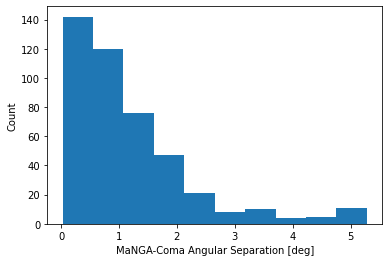

In [12]:
plt.hist(sep[MaNGA_in_Coma].to_value('degree'))
plt.xlabel('MaNGA-Coma Angular Separation [deg]')
plt.ylabel('Count')

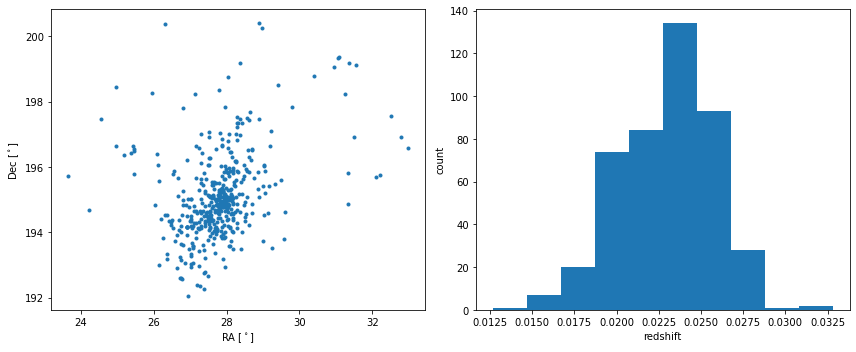

In [13]:
fig, axes = plt.subplots(1,2, figsize=(12,5), tight_layout=True)
ax = axes[0]
ax.plot(inComa_MaNGA_table['objdec'], inComa_MaNGA_table['objra'], '.')
ax.set(xlabel=r'RA [$^\circ$]', ylabel='Dec [$^\circ$]')
ax = axes[1]
ax.hist(inComa_MaNGA_table['z'])
ax.set(xlabel='redshift', ylabel='count');

# Cancer

In [14]:
cancer_nest = 100030

cancer_row_t3 = table3['Nest'] == cancer_nest

R2t_cancer = table3['R2t'][cancer_row_t3][0]
sigma_cancer = table3['sigP'][cancer_row_t3][0]

In [15]:
cancer_coords = SkyCoord(table3['SGLON'][cancer_row_t3]*u.degree, 
                       table3['SGLAT'][cancer_row_t3]*u.degree, 
                       frame='supergalactic')

cancer_group_coords = SkyCoord(table2['SGLON']*u.degree, 
                        table2['SGLAT']*u.degree, 
                        frame='supergalactic')

idx, d2d, d3d = cancer_coords.match_to_catalog_sky(cancer_group_coords)

V_cancer = table2['__HV_'][idx][0]

In [16]:
# First, we need to convert R2t from Mpc to an angle, using the group's heliocentric velocity
R2t_cancer_angle = (R2t_cancer/(V_cancer/H0))*u.radian

In [17]:
cancer_tf_coords = SkyCoord(drpall['objra'], drpall['objdec'], unit='deg')

cancersep = cancer_coords.separation(cancer_tf_coords)

In [18]:
MaNGA_in_cancer1 = (cancersep < 1.5*R2t_cancer_angle) & (drpall['z']*c > V_cancer - 3*sigma_cancer) & (drpall['z']*c < V_cancer + 3*sigma_cancer)

MaNGA_in_cancer2 = (cancersep >= 1.5*R2t_cancer_angle) & (cancersep < 3*R2t_cancer_angle) & (drpall['z']*c > V_cancer - 2*sigma_cancer) & (drpall['z']*c < V_cancer + 2*sigma_cancer)

MaNGA_in_cancer = MaNGA_in_cancer1 | MaNGA_in_cancer2

################################################################################
# Keep all instances of each SGA_ID that are within the Coma cluster
#-------------------------------------------------------------------------------
MaNGA_ID_in_cancer = np.unique(drpall['mangaid'][MaNGA_in_cancer])

idx_MaNGA_in_cancer = np.in1d(drpall['mangaid'], MaNGA_ID_in_cancer)

inCancer_MaNGA_table = drpall[idx_MaNGA_in_cancer]
################################################################################

inCancer_MaNGA_table

plate,ifudsgn,plateifu,mangaid,versdrp2,versdrp3,verscore,versutil,versprim,platetyp,srvymode,objra,objdec,ifuglon,ifuglat,ifura,ifudec,ebvgal,nexp,exptime,drp3qual,bluesn2,redsn2,harname,frlplug,cartid,designid,cenra,cendec,airmsmin,airmsmed,airmsmax,seemin,seemed,seemax,transmin,transmed,transmax,mjdmin,mjdmed,mjdmax,gfwhm,rfwhm,ifwhm,zfwhm,mngtarg1,mngtarg2,mngtarg3,catidnum,plttarg,manga_tileid,nsa_iauname,ifudesignsize,ifutargetsize,ifudesignwrongsize,z,zmin,zmax,szmin,szmax,ezmin,ezmax,probs,pweight,psweight,psrweight,sweight,srweight,eweight,esweight,esrweight,nsa_field,nsa_run,nsa_camcol,nsa_version,nsa_nsaid,nsa_nsaid_v1b,nsa_z,nsa_zdist,nsa_sersic_absmag [7],nsa_elpetro_absmag [7],nsa_elpetro_amivar [7],nsa_sersic_mass,nsa_elpetro_mass,nsa_elpetro_ba,nsa_elpetro_phi,nsa_extinction [7],nsa_elpetro_th50_r,nsa_petro_th50,nsa_petro_flux [7],nsa_petro_flux_ivar [7],nsa_elpetro_flux [7],nsa_elpetro_flux_ivar [7],nsa_sersic_ba,nsa_sersic_n,nsa_sersic_phi,nsa_sersic_th50,nsa_sersic_flux [7],nsa_sersic_flux_ivar [7]
int64,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,float64,bytes53,int64,bytes32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,bytes32,int64,bytes19,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,bytes6,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
10219,12701,10219-12701,1-384262,v3_1_1,v3_1_1,v1_9_1,v5_5_36,v2_9,APOGEE-2&MaNGA,MaNGA dither,124.804460255,20.757476218,202.730852366,28.2045405067,124.80446,20.757476,0.0485511,9,8100.75,0,20.0905,41.3611,ma087,22,4,10676,125.1591,22.126518,1.02295,1.03572,1.08994,1.22475,1.36205,1.53061,0.939331,0.950341,0.956134,58107,58107,58107,2.52212,2.54318,2.55236,2.56663,4096,0,0,1,plateTargets-1.par,6647,J081913.06+204526.9,127,271,0,0.016806,0.0191604,0.0263371,0.0384104,0.0426346,0.0172462,0.0279859,0.67973,-999.0,-999.0,-999.0,-999.0,-999.0,1.15538,0.581344,0.620021,107,6728,4,v1_0_1,406620,-999,0.016806,0.0178075,-16.0373 .. -19.5024,-16.0286 .. -19.4064,9.81914 .. 948.582,4020110000.0,3801410000.0,0.673074,137.174,0.405918 .. 0.0724189,12.9645,11.0063,60.9813 .. 1797.59,0.00292266 .. 0.0018556,60.6471 .. 1921.47,0.00319726 .. 0.00207055,0.624158,1.62565,137.241,14.9023,61.4088 .. 2097.57,0.0105603 .. 0.00814692
10219,12705,10219-12705,1-605208,v3_1_1,v3_1_1,v1_9_1,v5_5_36,v2_9,APOGEE-2&MaNGA,MaNGA dither,125.967743522,21.4186635506,202.450752176,29.4515242385,125.96774,21.418664,0.048269,9,8100.75,0,19.53,43.0777,ma176,36,4,10676,125.1591,22.126518,1.02008,1.03032,1.0943,1.22475,1.36205,1.53061,0.939331,0.950341,0.956134,58107,58107,58107,2.38953,2.3371,2.31221,2.29223,1552,0,0,1,plateTargets-1.par,6647,J082352.09+212501.0,127,169,0,0.0169954,0.0155674,0.024127,0.0335348,0.0362204,0.0150544,0.0288411,0.67973,1.88092,1.06814,1.12941,-999.0,-999.0,0.942542,0.682353,0.706853,209,6597,5,v1_0_1,647445,-999,0.0169954,0.0179335,-14.313 .. -18.7407,-14.9596 .. -18.5598,10.999 .. 782.111,2087590000.0,1699700000.0,0.380127,134.57,0.400899 .. 0.0715235,10.5663,10.5741,8.48385 .. 786.021,0.0112217 .. 0.0013472,21.7814 .. 868.092,0.0278192 .. 0.00413187,0.256699,1.61229,134.633,14.6294,11.9613 .. 1024.83,0.0862699 .. 0.0183595
10219,1901,10219-1901,1-384189,v3_1_1,v3_1_1,v1_9_1,v5_5_36,v2_9,APOGEE-2&MaNGA,MaNGA dither,125.14376637,21.1054663161,202.485390112,28.6227800695,125.14377,21.105466,0.0425669,9,8100.75,0,20.0905,41.3611,ma080,29,4,10676,125.1591,22.126518,1.02148,1.03349,1.09043,1.22475,1.36205,1.53061,0.939331,0.950341,0.956134,58107,58107,58107,2.54118,2.48445,2.45348,2.42535,1168

Text(0, 0.5, 'Count')

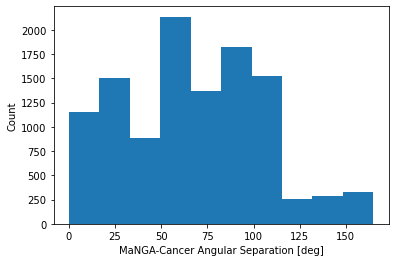

In [19]:
plt.hist(cancersep.to_value('degree'))
plt.xlabel('MaNGA-Cancer Angular Separation [deg]')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

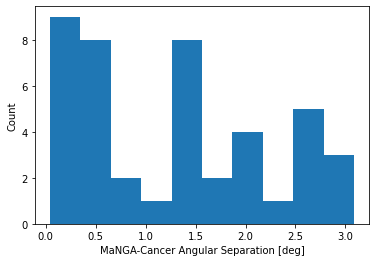

In [20]:
plt.hist(cancersep[MaNGA_in_cancer].to_value('degree'))
plt.xlabel('MaNGA-Cancer Angular Separation [deg]')
plt.ylabel('Count')

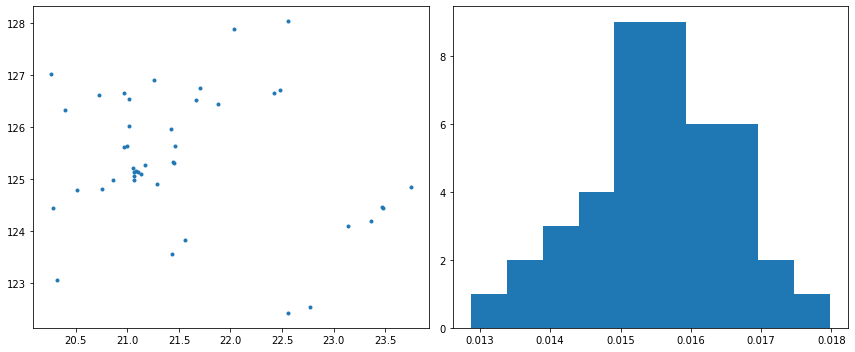

In [21]:
fig, axes = plt.subplots(1,2, figsize=(12,5), tight_layout=True)
ax = axes[0]
ax.plot(inCancer_MaNGA_table['objdec'], inCancer_MaNGA_table['objra'], '.')
ax = axes[1]
ax.hist(inCancer_MaNGA_table['z']);

# Abell 2151

In [22]:
a2151_nest = 100007

a2151_row_t3 = table3['Nest'] == a2151_nest

R2t_a2151 = table3['R2t'][a2151_row_t3][0]
sigma_a2151 = table3['sigP'][a2151_row_t3][0]

In [23]:
a2151_coords = SkyCoord(table3['SGLON'][a2151_row_t3]*u.degree, 
                       table3['SGLAT'][a2151_row_t3]*u.degree, 
                       frame='supergalactic')

a2151_group_coords = SkyCoord(table2['SGLON']*u.degree, 
                        table2['SGLAT']*u.degree, 
                        frame='supergalactic')

idx, d2d, d3d = a2151_coords.match_to_catalog_sky(a2151_group_coords)

V_a2151 = table2['__HV_'][idx][0]

In [24]:
# First, we need to convert R2t from Mpc to an angle, using the group's heliocentric velocity
R2t_a2151_angle = (R2t_a2151/(V_a2151/H0))*u.radian

In [25]:
a2151_tf_coords = SkyCoord(drpall['objra'], drpall['objdec'], unit='deg')

a21sep = a2151_coords.separation(a2151_tf_coords)

In [26]:
MaNGA_in_a21511 = (a21sep < 1.5*R2t_a2151_angle) & (drpall['z']*c > V_a2151 - 3*sigma_a2151) & (drpall['z']*c < V_a2151 + 3*sigma_a2151)

MaNGA_in_a21512 = (a21sep >= 1.5*R2t_a2151_angle) & (a21sep < 3*R2t_a2151_angle) & (drpall['z']*c > V_a2151 - 2*sigma_a2151) & (drpall['z']*c < V_a2151 + 2*sigma_a2151)

MaNGA_in_a2151 = MaNGA_in_a21511 | MaNGA_in_a21512

################################################################################
# Keep all instances of each SGA_ID that are within the Coma cluster
#-------------------------------------------------------------------------------
MaNGA_ID_in_a2151 = np.unique(drpall['mangaid'][MaNGA_in_a2151])

idx_MaNGA_in_a2151 = np.in1d(drpall['mangaid'], MaNGA_ID_in_a2151)

inAbell2151_MaNGA_table = drpall[idx_MaNGA_in_a2151]
################################################################################

#inAbell2151_MaNGA_table

Text(0, 0.5, 'Count')

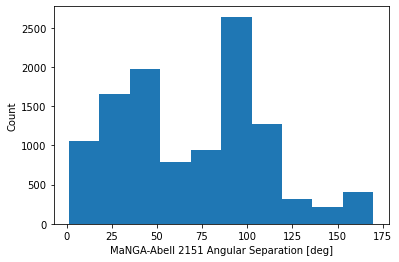

In [27]:
plt.hist(a21sep.to_value('degree'))
plt.xlabel('MaNGA-Abell 2151 Angular Separation [deg]')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

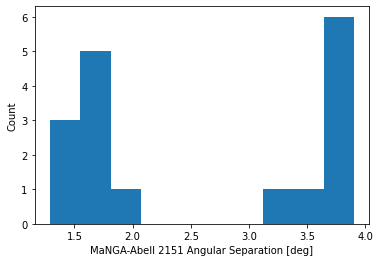

In [28]:
plt.hist(a21sep[MaNGA_in_a2151].to_value('degree'))
plt.xlabel('MaNGA-Abell 2151 Angular Separation [deg]')
plt.ylabel('Count')

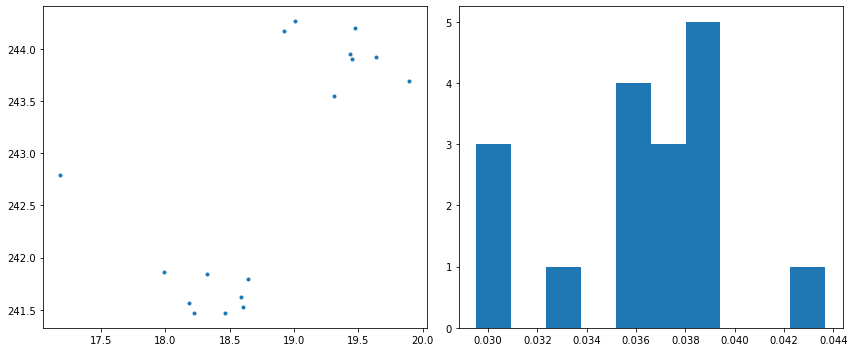

In [29]:
fig, axes = plt.subplots(1,2, figsize=(12,5), tight_layout=True)
ax = axes[0]
ax.plot(inAbell2151_MaNGA_table['objdec'], inAbell2151_MaNGA_table['objra'], '.')
ax = axes[1]
ax.hist(inAbell2151_MaNGA_table['z']);

# Ursa Major

In [38]:
ursa_nest = 100008

ursa_row_t3 = table3['Nest'] == ursa_nest

R2t_ursa = table3['R2t'][ursa_row_t3][0]
sigma_ursa = table3['sigP'][ursa_row_t3][0]

In [39]:
ursa_coords = SkyCoord(table3['SGLON'][ursa_row_t3]*u.degree, 
                       table3['SGLAT'][ursa_row_t3]*u.degree, 
                       frame='supergalactic')

ursa_group_coords = SkyCoord(table2['SGLON']*u.degree, 
                        table2['SGLAT']*u.degree, 
                        frame='supergalactic')

idx, d2d, d3d = ursa_coords.match_to_catalog_sky(ursa_group_coords)

V_ursa = table2['__HV_'][idx][0]

In [40]:
# First, we need to convert R2t from Mpc to an angle, using the group's heliocentric velocity
R2t_ursa_angle = (R2t_ursa/(V_ursa/H0))*u.radian

In [41]:
ursa_tf_coords = SkyCoord(drpall['objra'], drpall['objdec'], unit='deg')

usep = ursa_coords.separation(ursa_tf_coords)

In [43]:
MaNGA_in_ursa1 = (usep < 1.5*R2t_ursa_angle) & (drpall['z']*c > V_ursa - 3*sigma_ursa) & (drpall['z']*c < V_ursa + 3*sigma_ursa)

MaNGA_in_ursa2 = (usep >= 1.5*R2t_ursa_angle) & (usep < 3*R2t_ursa_angle) & (drpall['z']*c > V_ursa - 2*sigma_ursa) & (drpall['z']*c < V_ursa + 2*sigma_ursa)

MaNGA_in_ursa = MaNGA_in_ursa1 | MaNGA_in_ursa2

################################################################################
# Keep all instances of each SGA_ID that are within the Coma cluster
#-------------------------------------------------------------------------------
MaNGA_ID_in_ursa = np.unique(drpall['mangaid'][MaNGA_in_ursa])

idx_MaNGA_in_ursa = np.in1d(drpall['mangaid'], MaNGA_ID_in_ursa)

inUrsaMajor_MaNGA_table = drpall[idx_MaNGA_in_ursa]
################################################################################

#inUrsaMajor_MaNGA_table

# NGC 4065

In [44]:
ngc4065_nest = 100018

ngc4065_row_t3 = table3['Nest'] == ngc4065_nest

R2t_ngc4065 = table3['R2t'][ngc4065_row_t3][0]
sigma_ngc4065 = table3['sigP'][ngc4065_row_t3][0]

In [45]:
ngc4065_coords = SkyCoord(table3['SGLON'][ngc4065_row_t3]*u.degree, 
                       table3['SGLAT'][ngc4065_row_t3]*u.degree, 
                       frame='supergalactic')

ngc4065_group_coords = SkyCoord(table2['SGLON']*u.degree, 
                        table2['SGLAT']*u.degree, 
                        frame='supergalactic')

idx, d2d, d3d = ngc4065_coords.match_to_catalog_sky(ngc4065_group_coords)

V_ngc4065 = table2['__HV_'][idx][0]

In [46]:
# First, we need to convert R2t from Mpc to an angle, using the group's heliocentric velocity
R2t_ngc4065_angle = (R2t_ngc4065/(V_ngc4065/H0))*u.radian

In [47]:
ngc4065_tf_coords = SkyCoord(drpall['objra'], drpall['objdec'], unit='deg')

ngc40sep = ngc4065_coords.separation(ngc4065_tf_coords)

In [48]:
MaNGA_in_ngc40651 = (ngc40sep < 1.5*R2t_ngc4065_angle) & (drpall['z']*c > V_ngc4065 - 3*sigma_ngc4065) & (drpall['z']*c < V_ngc4065 + 3*sigma_ngc4065)

MaNGA_in_ngc40652 = (ngc40sep >= 1.5*R2t_ngc4065_angle) & (ngc40sep < 3*R2t_ngc4065_angle) & (drpall['z']*c > V_ngc4065 - 2*sigma_ngc4065) & (drpall['z']*c < V_ngc4065 + 2*sigma_ngc4065)

MaNGA_in_ngc4065 = MaNGA_in_ngc40651 | MaNGA_in_ngc40652

################################################################################
# Keep all instances of each SGA_ID that are within the Coma cluster
#-------------------------------------------------------------------------------
MaNGA_ID_in_ngc4065 = np.unique(drpall['mangaid'][MaNGA_in_ngc4065])

idx_MaNGA_in_ngc4065 = np.in1d(drpall['mangaid'], MaNGA_ID_in_ngc4065)

inNGC4065_MaNGA_table = drpall[idx_MaNGA_in_ngc4065]
################################################################################

inNGC4065_MaNGA_table

plate,ifudsgn,plateifu,mangaid,versdrp2,versdrp3,verscore,versutil,versprim,platetyp,srvymode,objra,objdec,ifuglon,ifuglat,ifura,ifudec,ebvgal,nexp,exptime,drp3qual,bluesn2,redsn2,harname,frlplug,cartid,designid,cenra,cendec,airmsmin,airmsmed,airmsmax,seemin,seemed,seemax,transmin,transmed,transmax,mjdmin,mjdmed,mjdmax,gfwhm,rfwhm,ifwhm,zfwhm,mngtarg1,mngtarg2,mngtarg3,catidnum,plttarg,manga_tileid,nsa_iauname,ifudesignsize,ifutargetsize,ifudesignwrongsize,z,zmin,zmax,szmin,szmax,ezmin,ezmax,probs,pweight,psweight,psrweight,sweight,srweight,eweight,esweight,esrweight,nsa_field,nsa_run,nsa_camcol,nsa_version,nsa_nsaid,nsa_nsaid_v1b,nsa_z,nsa_zdist,nsa_sersic_absmag [7],nsa_elpetro_absmag [7],nsa_elpetro_amivar [7],nsa_sersic_mass,nsa_elpetro_mass,nsa_elpetro_ba,nsa_elpetro_phi,nsa_extinction [7],nsa_elpetro_th50_r,nsa_petro_th50,nsa_petro_flux [7],nsa_petro_flux_ivar [7],nsa_elpetro_flux [7],nsa_elpetro_flux_ivar [7],nsa_sersic_ba,nsa_sersic_n,nsa_sersic_phi,nsa_sersic_th50,nsa_sersic_flux [7],nsa_sersic_flux_ivar [7]
int64,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,float64,bytes53,int64,bytes32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,bytes32,int64,bytes19,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,bytes6,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
8310,12702,8310-12702,1-494684,v3_1_1,v3_1_1,v1_9_1,v5_5_36,v2_9,APOGEE-2&MaNGA,MaNGA dither,178.474223049,22.0356704467,231.08670667,75.9742739547,178.47422,22.03567,0.0315981,12,10800.8,0,22.3921,52.9649,ma134,25,6,8823,179.27495,22.686079,1.01827,1.0317,1.08563,1.13453,1.35004,1.49692,0.610029,0.844181,0.900027,58581,58582,58582,2.36733,2.37893,2.38392,2.38578,1168,0,0,1,plateTargets-1.par,6137,J115353.79+220208.3,127,91,127,0.0255917,0.0191029,0.0262964,0.0383271,0.0425522,0.0158404,0.0313921,0.67973,1.72735,0.69915,0.755623,-999.0,-999.0,0.720715,0.446649,0.469043,423,5194,3,v1_0_1,523092,-999,0.0255917,0.0253246,-14.0272 .. -19.7547,-13.8064 .. -19.4988,0.210208 .. 864.938,5907900000.0,5150100000.0,0.513016,29.5659,0.260249 .. 0.0464305,7.82651,6.39049,5.34615 .. 965.55,0.00966711 .. 0.00301093,4.43093 .. 1039.83,0.0126257 .. 0.00425627,0.364637,2.04622,31.404,10.1472,5.26348 .. 1301.92,0.044326 .. 0.0151345
8310,12705,8310-12705,1-495360,v3_1_1,v3_1_1,v1_9_1,v5_5_36,v2_9,APOGEE-2&MaNGA,MaNGA dither,179.561883968,21.8997431582,233.43078982,76.8301614093,179.56188,21.899743,0.0298429,12,10800.8,0,26.2984,50.27,ma175,36,6,8823,179.27495,22.686079,1.01847,1.02945,1.07963,1.13453,1.35004,1.49692,0.610029,0.844181,0.900027,58581,58582,58582,2.45466,2.37887,2.35707,2.33681,1168,0,64,1,plateTargets-1.par,6137,J115814.84+215359.2,127,61,0,0.0206257,0.0137258,0.0231398,0.0311729,0.0297754,0.0137258,0.0265428,0.67973,1.96833,1.96833,1.96833,-999.0,-999.0,1.20152,1.20152,1.20152,315,5183,2,v1_0_1,523788,-999,0.0206257,0.0205375,-13.4451 .. -18.3523,-13.8705 .. -18.2641,1.2237 .. 644.695,1272590000.0,1023290000.0,0.407376,27.8682,0.241588 .. 0.0431011,5.98558,4.54868,4.5681 .. 511.523,0.024586 .. 0.00512595,6.95892 .. 506.79,0.0298463 .. 0.00704906,0.215343,1.3265,27.5347,7.23272,4.84516 .. 548.246,0.108144 .. 0.0378355


# Virgo

In [49]:
virgo_nest = 100002

virgo_row_t3 = table3['Nest'] == virgo_nest

R2t_virgo = table3['R2t'][virgo_row_t3][0]
sigma_virgo = table3['sigP'][virgo_row_t3][0]

In [50]:
virgo_coords = SkyCoord(table3['SGLON'][virgo_row_t3]*u.degree, 
                       table3['SGLAT'][virgo_row_t3]*u.degree, 
                       frame='supergalactic')

v_group_coords = SkyCoord(table2['SGLON']*u.degree, 
                        table2['SGLAT']*u.degree, 
                        frame='supergalactic')

idx, d2d, d3d = virgo_coords.match_to_catalog_sky(v_group_coords)

V_virgo = table2['__HV_'][idx][0]

In [51]:
# First, we need to convert R2t from Mpc to an angle, using the group's heliocentric velocity
R2t_virgo_angle = (R2t_virgo/(V_virgo/H0))*u.radian

In [52]:
v_tf_coords = SkyCoord(drpall['objra'], drpall['objdec'], unit='deg')

vsep = virgo_coords.separation(v_tf_coords)

In [1]:
MaNGA_in_virgo1 = (vsep < 1.5*R2t_virgo_angle) & (drpall['z']*c > V_virgo - 3*sigma_virgo) & (drpall['z']*c < V_virgo + 3*sigma_virgo)

MaNGA_in_virgo2 = (vsep >= 1.5*R2t_virgo_angle) & (vsep < 3*R2t_virgo_angle) & (drpall['z']*c > V_virgo - 2*sigma_virgo) & (drpall['z']*c < V_virgo + 2*sigma_virgo)

MaNGA_in_virgo = MaNGA_in_virgo1 | MaNGA_in_virgo2

################################################################################
# Keep all instances of each SGA_ID that are within the Coma cluster
#-------------------------------------------------------------------------------
MaNGA_ID_in_virgo = np.unique(drpall['mangaid'][MaNGA_in_virgo])

idx_MaNGA_in_virgo = np.in1d(drpall['mangaid'], MaNGA_ID_in_virgo)

inVirgo_MaNGA_table = drpall[idx_MaNGA_in_virgo]
################################################################################

inVirgo_MaNGA_table

NameError: name 'vsep' is not defined

# Galaxy Zoo

Morphological classifications from Galaxy Zoo, [defined here](https://www.sdss.org/dr17/data_access/value-added-catalogs/?vac_id=galaxy-zoo-classifications-for-manga-galaxies).

Description of the data model is [provided here](https://data.sdss.org/datamodel/files/MANGA_MORPHOLOGY/galaxyzoo/MaNGA_gz.html).

In [30]:
hdu = fits.open('MaNGA_gz-v2_0_1.fits')
gz = Table(hdu[1].data)
hdu.close()

gz[:100]

PLATEIFU,MANGAID,OBJRA,OBJDEC,Z,MNGTARG1,MNGTARG2,MNGTARG3,IFUDESIGNSIZE,crossmatch_separation,dr7objid,gz2_class,total_classifications,total_votes,t01_smooth_or_features_a01_smooth_count,t01_smooth_or_features_a01_smooth_weight,t01_smooth_or_features_a01_smooth_fraction,t01_smooth_or_features_a01_smooth_weighted_fraction,t01_smooth_or_features_a01_smooth_debiased,t01_smooth_or_features_a01_smooth_flag,t01_smooth_or_features_a02_features_or_disk_count,t01_smooth_or_features_a02_features_or_disk_weight,t01_smooth_or_features_a02_features_or_disk_fraction,t01_smooth_or_features_a02_features_or_disk_weighted_fraction,t01_smooth_or_features_a02_features_or_disk_debiased,t01_smooth_or_features_a02_features_or_disk_flag,t01_smooth_or_features_a03_star_or_artifact_count,t01_smooth_or_features_a03_star_or_artifact_weight,t01_smooth_or_features_a03_star_or_artifact_fraction,t01_smooth_or_features_a03_star_or_artifact_weighted_fraction,t01_smooth_or_features_a03_star_or_artifact_debiased,t01_smooth_or_features_a03_star_or_artifact_flag,t02_edgeon_a04_yes_count,t02_edgeon_a04_yes_weight,t02_edgeon_a04_yes_fraction,t02_edgeon_a04_yes_weighted_fraction,t02_edgeon_a04_yes_debiased,t02_edgeon_a04_yes_flag,t02_edgeon_a05_no_count,t02_edgeon_a05_no_weight,t02_edgeon_a05_no_fraction,t02_edgeon_a05_no_weighted_fraction,t02_edgeon_a05_no_debiased,t02_edgeon_a05_no_flag,t03_bar_a06_bar_count,t03_bar_a06_bar_weight,t03_bar_a06_bar_fraction,t03_bar_a06_bar_weighted_fraction,t03_bar_a06_bar_debiased,t03_bar_a06_bar_flag,t03_bar_a07_no_bar_count,t03_bar_a07_no_bar_weight,t03_bar_a07_no_bar_fraction,t03_bar_a07_no_bar_weighted_fraction,t03_bar_a07_no_bar_debiased,t03_bar_a07_no_bar_flag,t04_spiral_a08_spiral_count,t04_spiral_a08_spiral_weight,t04_spiral_a08_spiral_fraction,t04_spiral_a08_spiral_weighted_fraction,t04_spiral_a08_spiral_debiased,t04_spiral_a08_spiral_flag,t04_spiral_a09_no_spiral_count,t04_spiral_a09_no_spiral_weight,t04_spiral_a09_no_spiral_fraction,t04_spiral_a09_no_spiral_weighted_fraction,t04_spiral_a09_no_spiral_debiased,t04_spiral_a09_no_spiral_flag,t05_bulge_prominence_a10_no_bulge_count,t05_bulge_prominence_a10_no_bulge_weight,t05_bulge_prominence_a10_no_bulge_fraction,t05_bulge_prominence_a10_no_bulge_weighted_fraction,t05_bulge_prominence_a10_no_bulge_debiased,t05_bulge_prominence_a10_no_bulge_flag,t05_bulge_prominence_a11_just_noticeable_count,t05_bulge_prominence_a11_just_noticeable_weight,t05_bulge_prominence_a11_just_noticeable_fraction,t05_bulge_prominence_a11_just_noticeable_weighted_fraction,t05_bulge_prominence_a11_just_noticeable_debiased,t05_bulge_prominence_a11_just_noticeable_flag,t05_bulge_prominence_a12_obvious_count,t05_bulge_prominence_a12_obvious_weight,t05_bulge_prominence_a12_obvious_fraction,t05_bulge_prominence_a12_obvious_weighted_fraction,t05_bulge_prominence_a12_obvious_debiased,t05_bulge_prominence_a12_obvious_flag,t05_bulge_prominence_a13_dominant_count,t05_bulge_prominence_a13_dominant_weight,t05_bulge_prominence_a13_dominant_fraction,t05_bulge_prominence_a13_dominant_weighted_fraction,t05_bulge_prominence_a13_dominant_debiased,t05_bulge_prominence_a13_dominant_flag,t06_odd_a14_yes_count,t06_odd_a14_yes_weight,t06_odd_a14_yes_fraction,t06_odd_a14_yes_weighted_fraction,t06_odd_a14_yes_debiased,t06_odd_a14_yes_flag,t06_odd_a15_no_count,t06_odd_a15_no_weight,t06_odd_a15_no_fraction,t06_odd_a15_no_weighted_fraction,t06_odd_a15_no_debiased,t06_odd_a15_no_flag,t07_rounded_a16_completely_round_count,t07_rounded_a16_completely_round_weight,t07_rounded_a16_completely_round_fraction,t07_rounded_a16_completely_round_weighted_fraction,t07_rounded_a16_completely_round_debiased,t07_rounded_a16_completely_round_flag,t07_rounded_a17_in_between_count,t07_rounded_a17_in_between_weight,t07_rounded_a17_in_between_fraction,t07_rounded_a17_in_between_weighted_fraction,t07_rounded_a17_in_between_debiased,t07_rounded_a17_in_between_flag,t07_rounded_a18_cigar_shaped_count,t07_rounded_a18_cigar_shaped_weight,t07_rounded_a18_cig

# Visual Morphology

Visual morphology from SDSS and DECaLS images, [defined here](https://www.sdss.org/dr17/data_access/value-added-catalogs/?vac_id=manga-visual-morphologies-from-sdss-and-desi-images).

Data model is [defined here](https://data.sdss.org/datamodel/files/MANGA_MORPHOLOGY/manga_visual_morpho/1.0.1/manga_visual_morpho.html).

In [31]:
hdu = fits.open('manga_visual_morpho-1.0.1.fits')
visual = Table(hdu[1].data)
hdu.close()

visual[:9000]

name,plateifu,MANGAID,objra,objdec,Type,TType,edge_on,tidal,C,E_C,A,E_A,S,E_S
str17,str11,str9,float64,float64,str6,int16,int16,int16,float32,float32,float32,float32,float32,float32
manga-10001-12701,10001-12701,1-48157,133.371090612,57.5984251446,Sbc,4,0,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
manga-10001-12702,10001-12702,1-48188,133.685669869,57.4802503218,SABbc,4,0,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
manga-10001-12703,10001-12703,1-55648,136.017159969,57.0923291779,Sbc,4,0,0,3.296,0.055,0.13,0.019,-0.71,0.857
manga-10001-12704,10001-12704,1-55616,133.989966869,57.6779676669,S,11,1,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
manga-10001-12705,10001-12705,1-55784,136.75137451,57.4514369241,Sbc,4,0,0,2.903,0.046,0.125,0.015,0.53,0.676
manga-10001-1901,10001-1901,1-55567,133.330028009,57.0411553708,S0,-2,0,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
manga-10001-1902,10001-1902,1-48201,134.193923352,56.7867469988,SBa,1,0,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
manga-10001-3701,10001-3701,1-48111,132.465646765,57.1437279024,S0,-2,0,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
manga-10001-3702,10001-3702,1-48136,132.912768243,57.1074235568,E,-5,0,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0


# Deep Learning

[Deep learning VAC](https://www.sdss.org/dr17/data_access/value-added-catalogs/?vac_id=manga-morphology-deep-learning-dr17-catalog) with galaxy morphology, specific to DR17.

The data model specifying the column values is [given here](https://data.sdss.org/datamodel/files/MANGA_MORPHOLOGY/deep_learning/DL_VER/manga-morphology-dl.html).

In [32]:
hdu = fits.open('manga-morphology-dl-DR17.fits')
dl = Table(hdu[1].data)
hdu.close()

dl[:100]

INTID,MANGA_ID,PLATEIFU,OBJID,RA,DEC,Z,DUPL_GR,DUPL_N,DUPL_ID,T-Type,T-Type_std,P_LTG,P_LTG_std,P_S0,P_S0_std,P_edge,P_edge_std,P_bar,P_bar_std,Visual_Class,Visual_Flag
int16,str9,str15,int64,float64,float64,float64,int16,int16,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,int16
1,1-286558,8325-12701,1237661435926544550,210.17634,45.833422,0.04288710891658048,0,0,0,4.221438407897949,0.6632512920115043,0.9802886247634888,0.023341917289120134,0.938228964805603,0.12361474624591347,0.0039536390686407685,0.065356233171725,0.45846888422966003,0.065356233171725,3,0
2,1-274706,8253-12701,1237660634384761005,157.05886,42.96805,0.04496037553087202,0,0,0,4.378849506378174,1.0630811776112241,0.999234676361084,0.0012762211396711856,0.9836623072624207,0.144277846757422,0.9999891519546509,0.00016300611310054642,0.10297111421823502,0.00016300611310054642,3,0
3,1-201874,8938-12701,1237657118405886241,119.75748,30.976025,0.05276287200043103,0,0,0,3.3679091930389404,0.6427940112443938,0.927117645740509,0.12398989623522808,0.8620888590812683,0.12167109396230592,0.6124326288700104,0.146001299579978,0.16775675863027573,0.146001299579978,3,0
4,1-626658,8983-12701,1237667323264368802,203.83021,26.424781,0.02535624535944735,0,0,0,3.3002166748046875,0.7500633033353644,0.9808579385280609,0.023036707681772097,0.9125989377498627,0.1421640087995252,0.006133790244348347,0.02660665703469211,0.18608582764863968,0.02660665703469211,3,0
5,1-24425,8626-12701,1237656529994055837,263.52527,56.799613,0.02923735792806886,0,0,0,-0.22833305597305298,0.5620976832249787,0.062017541378736496,0.0343759162684501,0.2607986405491829,0.20289286953115845,0.03328006900846958,0.07390042108431057,0.157500758767128,0.07390042108431057,1,0
6,1-385070,9501-12701,1237664668424667344,129.89352,25.477089,0.02918049726283862,0,0,0,5.5539751052856445,1.0346164326088745,0.9948531091213226,0.011397733314282586,0.9820498526096344,0.1366270772213304,3.119309752719346e-07,2.5032462500125135e-06,0.06437770463526249,2.5032462500125135e-06,3,0
7,1-455661,8931-12701,1237667442437259402,192.88862,26.769826,0.04561212218107418,0,0,0,3.955049514770508,0.7488214782734656,0.9717792272567749,0.04076767641810579,0.856835663318634,0.13482047899479113,0.0016506986576132476,0.04093541945456329,0.8361897468566895,0.04093541945456329,3,0
8,1-321655,9033-12701,1237662302437179644,221.97538,46.514929,0.08674015114209274,0,0,0,0.6884464621543884,0.7112244616559166,0.43974047899246216,0.22112363537448873,0.7472379207611084,0.15556161435425664,0.0018360039102844894,0.035489573540573555,0.17628274857997894,0.035489573540573555,2,1
9,1-24003,8625-12701,1237651211750932696,257.95754,57.110933,0.03027913690175131,0,0,0,0.07904273271560669,0.6390580005586807,0.19968923181295395,0.20868281671729408,0.4820563644170761,0.15904526176965755,0.28534209728240967,0.13637724989039438,0.9737994968891144,0.13637724989039438,3,1


# Coma Morphology

In [39]:
# vis_Coma = join(inComa_MaNGA_table, visual, keys_left='objra', keys_right='objra')
#gz_Coma = join(inComa_MaNGA_table, gz, keys_left='objra', keys_right='OBJRA')
#dl_Coma = join(inComa_MaNGA_table, dl, keys_left='objra', keys_right='RA')

In [34]:
x = copy(inComa_MaNGA_table)
x['mangaid_str'] = np.asarray([_.strip() for _ in inComa_MaNGA_table['mangaid']])

y = copy(visual['name', 'Type', 'TType', 'edge_on', 'tidal', 'C', 'E_C', 'A', 'E_A', 'S', 'E_S'])
y['mangaid_str'] = np.asarray([_.strip() for _ in visual['MANGAID']])

vis_Coma = join(x, y, keys=['mangaid_str'])
vis_Coma

plate,ifudsgn,plateifu,mangaid,versdrp2,versdrp3,verscore,versutil,versprim,platetyp,srvymode,objra,objdec,ifuglon,ifuglat,ifura,ifudec,ebvgal,nexp,exptime,drp3qual,bluesn2,redsn2,harname,frlplug,cartid,designid,cenra,cendec,airmsmin,airmsmed,airmsmax,seemin,seemed,seemax,transmin,transmed,transmax,mjdmin,mjdmed,mjdmax,gfwhm,rfwhm,ifwhm,zfwhm,mngtarg1,mngtarg2,mngtarg3,catidnum,plttarg,manga_tileid,nsa_iauname,ifudesignsize,ifutargetsize,ifudesignwrongsize,z,zmin,zmax,szmin,szmax,ezmin,ezmax,probs,pweight,psweight,psrweight,sweight,srweight,eweight,esweight,esrweight,nsa_field,nsa_run,nsa_camcol,nsa_version,nsa_nsaid,nsa_nsaid_v1b,nsa_z,nsa_zdist,nsa_sersic_absmag [7],nsa_elpetro_absmag [7],nsa_elpetro_amivar [7],nsa_sersic_mass,nsa_elpetro_mass,nsa_elpetro_ba,nsa_elpetro_phi,nsa_extinction [7],nsa_elpetro_th50_r,nsa_petro_th50,nsa_petro_flux [7],nsa_petro_flux_ivar [7],nsa_elpetro_flux [7],nsa_elpetro_flux_ivar [7],nsa_sersic_ba,nsa_sersic_n,nsa_sersic_phi,nsa_sersic_th50,nsa_sersic_flux [7],nsa_sersic_flux_ivar [7],mangaid_str,name,Type,TType,edge_on,tidal,C,E_C,A,E_A,S,E_S
int64,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,float64,bytes53,int64,bytes32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,bytes32,int64,bytes19,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,bytes6,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str9,str17,str6,int16,int16,int16,float32,float32,float32,float32,float32,float32
8935,12704,8935-12704,1-403664,v3_1_1,v3_1_1,v1_9_1,v5_5_36,v2_9,APOGEE-2&MaNGA,MaNGA dither,196.973161414,28.3831807063,52.9013216101,86.1497673573,196.97316,28.383181,0.0112375,9,8100.82,0,24.585,47.6372,ma150,34,4,9555,195.773,28.079836,1.00741,1.02967,1.0683,1.43918,1.65008,1.77729,0.781102,0.894737,0.908246,57809,57809,57813,2.60742,2.54191,2.51992,2.49727,1168,0,0,1,plateTargets-1.par,6460,J130753.53+282259.2,127,91,0,0.0214205,0.0163857,0.0245873,0.0346038,0.0389111,0.0135221,0.028924,0.67973,1.84733,0.792952,0.854162,-999.0,-999.0,0.892505,0.54341,0.571475,96,4649,1,v1_0_1,426975,-999,0.0214205,0.0213315,-13.6555 .. -18.9031,-13.8326 .. -18.8666,104.418 .. 818.761,2632400000.0,2554090000.0,0.315209,20.1437,0.0949997 .. 0.0169487,7.39774,5.44272,7.79619 .. 831.622,1.68621 .. 0.00280161,7.4156 .. 844.027,2.68733 .. 0.00514928,0.193636,0.956294,20.4032,8.46251,6.28722 .. 871.195,4.18501 .. 0.0240506,1-403664,manga-8935-12704,Sc,5,1,0,3.263,0.052,0.198,0.016,1.07,1.011
8934,12705,8934-12705,1-403685,v3_1_1,v3_1_1,v1_9_1,v5_5_36,v2_9,APOGEE-2&MaNGA,MaNGA dither,196.817348641,28.2839220476,52.096790486,86.3105901669,196.81735,28.283922,0.0117786,9,8100.78,0,24.6194,43.2116,ma110,36,5,9554,195.42453,27.771593,1.00339,1.02209,1.11877,1.2653,1.40906,1.86723,0.774765,0.958241,0.983325,57459,57459,57460,2.49954,2.44089,2.43239,2.43167,1040,0,0,1,plateTargets-1.par,6449,J130716.16+281702.1,127,91,127,0.0248033,0.0219192,0.0287001,0.0428403,0.0471056,0.0192987,0.030525,0.67973,1.48106,0.576904,0.624794,-999.0,-999.0,0.914631,0.464784,0.495375,95,4649,1,v1_0_1,426998,-999,0.0248033,0.0247179,-12.601 .. -20.4385,-12.1161 .. -20.2611,1.62863 .. 960.419,12179900000.0,10319100000.0,0.687778,2.03145,0.0972733 .. 0.0173543,7.47504,6.8057,1.8814 .. 2250.54,1.23733 .. 0.00132577,1.13806 .. 2255.28,1.4862 .. 0.00164125,0.616024,3.25411,1.40253,9.90557,1.77482 .. 2657.01,5.35392 .. 0.00652222,1-403685,manga-8934-12705,SBa,1,0,0,3.959,0.067,0.097,0.012,0.25,0.392
8934,9102,8934-9102,1-403693,v3_1_1,v3_1_1,v1_9_1,v5_5_36,v2_9,APOGEE-2&MaNGA,MaNGA dither,196.

In [35]:
x = copy(inComa_MaNGA_table)
x['mangaid_str'] = np.asarray([_.strip() for _ in inComa_MaNGA_table['mangaid']])

y = copy(gz)
y['mangaid_str'] = np.asarray([_.strip() for _ in gz['MANGAID']])

gz_Coma = join(x, y, keys=['mangaid_str'])
gz_Coma

plate,ifudsgn,plateifu,mangaid,versdrp2,versdrp3,verscore,versutil,versprim,platetyp,srvymode,objra,objdec,ifuglon,ifuglat,ifura,ifudec,ebvgal,nexp,exptime,drp3qual,bluesn2,redsn2,harname,frlplug,cartid,designid,cenra,cendec,airmsmin,airmsmed,airmsmax,seemin,seemed,seemax,transmin,transmed,transmax,mjdmin,mjdmed,mjdmax,gfwhm,rfwhm,ifwhm,zfwhm,mngtarg1,mngtarg2,mngtarg3,catidnum,plttarg,manga_tileid,nsa_iauname,ifudesignsize,ifutargetsize,ifudesignwrongsize,z,zmin,zmax,szmin,szmax,ezmin,ezmax,probs,pweight,psweight,psrweight,sweight,srweight,eweight,esweight,esrweight,nsa_field,nsa_run,nsa_camcol,nsa_version,nsa_nsaid,nsa_nsaid_v1b,nsa_z,nsa_zdist,nsa_sersic_absmag [7],nsa_elpetro_absmag [7],nsa_elpetro_amivar [7],nsa_sersic_mass,nsa_elpetro_mass,nsa_elpetro_ba,nsa_elpetro_phi,nsa_extinction [7],nsa_elpetro_th50_r,nsa_petro_th50,nsa_petro_flux [7],nsa_petro_flux_ivar [7],nsa_elpetro_flux [7],nsa_elpetro_flux_ivar [7],nsa_sersic_ba,nsa_sersic_n,nsa_sersic_phi,nsa_sersic_th50,nsa_sersic_flux [7],nsa_sersic_flux_ivar [7],mangaid_str,PLATEIFU,MANGAID,OBJRA,OBJDEC,Z,MNGTARG1,MNGTARG2,MNGTARG3,IFUDESIGNSIZE,crossmatch_separation,dr7objid,gz2_class,total_classifications,total_votes,t01_smooth_or_features_a01_smooth_count,t01_smooth_or_features_a01_smooth_weight,t01_smooth_or_features_a01_smooth_fraction,t01_smooth_or_features_a01_smooth_weighted_fraction,t01_smooth_or_features_a01_smooth_debiased,t01_smooth_or_features_a01_smooth_flag,t01_smooth_or_features_a02_features_or_disk_count,t01_smooth_or_features_a02_features_or_disk_weight,t01_smooth_or_features_a02_features_or_disk_fraction,t01_smooth_or_features_a02_features_or_disk_weighted_fraction,t01_smooth_or_features_a02_features_or_disk_debiased,t01_smooth_or_features_a02_features_or_disk_flag,t01_smooth_or_features_a03_star_or_artifact_count,t01_smooth_or_features_a03_star_or_artifact_weight,t01_smooth_or_features_a03_star_or_artifact_fraction,t01_smooth_or_features_a03_star_or_artifact_weighted_fraction,t01_smooth_or_features_a03_star_or_artifact_debiased,t01_smooth_or_features_a03_star_or_artifact_flag,t02_edgeon_a04_yes_count,t02_edgeon_a04_yes_weight,t02_edgeon_a04_yes_fraction,t02_edgeon_a04_yes_weighted_fraction,t02_edgeon_a04_yes_debiased,t02_edgeon_a04_yes_flag,t02_edgeon_a05_no_count,t02_edgeon_a05_no_weight,t02_edgeon_a05_no_fraction,t02_edgeon_a05_no_weighted_fraction,t02_edgeon_a05_no_debiased,t02_edgeon_a05_no_flag,t03_bar_a06_bar_count,t03_bar_a06_bar_weight,t03_bar_a06_bar_fraction,t03_bar_a06_bar_weighted_fraction,t03_bar_a06_bar_debiased,t03_bar_a06_bar_flag,t03_bar_a07_no_bar_count,t03_bar_a07_no_bar_weight,t03_bar_a07_no_bar_fraction,t03_bar_a07_no_bar_weighted_fraction,t03_bar_a07_no_bar_debiased,t03_bar_a07_no_bar_flag,t04_spiral_a08_spiral_count,t04_spiral_a08_spiral_weight,t04_spiral_a08_spiral_fraction,t04_spiral_a08_spiral_weighted_fraction,t04_spiral_a08_spiral_debiased,t04_spiral_a08_spiral_flag,t04_spiral_a09_no_spiral_count,t04_spiral_a09_no_spiral_weight,t04_spiral_a09_no_spiral_fraction,t04_spiral_a09_no_spiral_weighted_fraction,t04_spiral_a09_no_spiral_debiased,t04_spiral_a09_no_spiral_flag,t05_bulge_prominence_a10_no_bulge_count,t05_bulge_prominence_a10_no_bulge_weight,t05_bulge_prominence_a10_no_bulge_fraction,t05_bulge_prominence_a10_no_bulge_weighted_fraction,t05_bulge_prominence_a10_no_bulge_debiased,t05_bulge_prominence_a10_no_bulge_flag,t05_bulge_prominence_a11_just_noticeable_count,t05_bulge_prominence_a11_just_noticeable_weight,t05_bulge_prominence_a11_just_noticeable_fraction,t05_bulge_prominence_a11_just_noticeable_weighted_fraction,t05_bulge_prominence_a11_just_noticeable_debiased,t05_bulge_prominence_a11_just_noticeable_flag,t05_bulge_prominence_a12_obvious_count,t05_bulge_prominence_a12_obvious_weight,t05_bulge_prominence_a12_obvious_fraction,t05_bulge_prominence_a12_obvious_weighted_fraction,t05_bulge_prominence_a12_obvious_debiased,t05_bulge_prominence_a12_obvious_flag,t05_bulge_prominence_a13_dominant_count,t05_bulge_prominence_a13_

In [41]:
x = copy(inComa_MaNGA_table)
x['mangaid_str'] = np.asarray([_.strip() for _ in inComa_MaNGA_table['mangaid']])

y = copy(dl)
y['mangaid_str'] = np.asarray([_.strip() for _ in dl['MANGA_ID']])

dl_Coma = join(x, y, keys=['mangaid_str'])
dl_Coma

plate,ifudsgn,plateifu,mangaid,versdrp2,versdrp3,verscore,versutil,versprim,platetyp,srvymode,objra,objdec,ifuglon,ifuglat,ifura,ifudec,ebvgal,nexp,exptime,drp3qual,bluesn2,redsn2,harname,frlplug,cartid,designid,cenra,cendec,airmsmin,airmsmed,airmsmax,seemin,seemed,seemax,transmin,transmed,transmax,mjdmin,mjdmed,mjdmax,gfwhm,rfwhm,ifwhm,zfwhm,mngtarg1,mngtarg2,mngtarg3,catidnum,plttarg,manga_tileid,nsa_iauname,ifudesignsize,ifutargetsize,ifudesignwrongsize,z,zmin,zmax,szmin,szmax,ezmin,ezmax,probs,pweight,psweight,psrweight,sweight,srweight,eweight,esweight,esrweight,nsa_field,nsa_run,nsa_camcol,nsa_version,nsa_nsaid,nsa_nsaid_v1b,nsa_z,nsa_zdist,nsa_sersic_absmag [7],nsa_elpetro_absmag [7],nsa_elpetro_amivar [7],nsa_sersic_mass,nsa_elpetro_mass,nsa_elpetro_ba,nsa_elpetro_phi,nsa_extinction [7],nsa_elpetro_th50_r,nsa_petro_th50,nsa_petro_flux [7],nsa_petro_flux_ivar [7],nsa_elpetro_flux [7],nsa_elpetro_flux_ivar [7],nsa_sersic_ba,nsa_sersic_n,nsa_sersic_phi,nsa_sersic_th50,nsa_sersic_flux [7],nsa_sersic_flux_ivar [7],mangaid_str,INTID,MANGA_ID,PLATEIFU,OBJID,RA,DEC,Z,DUPL_GR,DUPL_N,DUPL_ID,T-Type,T-Type_std,P_LTG,P_LTG_std,P_S0,P_S0_std,P_edge,P_edge_std,P_bar,P_bar_std,Visual_Class,Visual_Flag
int64,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,float64,bytes53,int64,bytes32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,bytes32,int64,bytes19,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,bytes6,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str9,int16,str9,str15,int64,float64,float64,float64,int16,int16,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,int16
12620,6102,12620-6102,1-401566,v3_1_1,v3_1_1,v1_9_1,v5_5_36,v2_9,APOGEE-2&MaNGA,MaNGA dither,200.249479878,28.9695033088,50.4143599775,83.2245991769,200.24948,28.969503,0.0151929,9,8100.53,4096,22.2766,46.6587,ma123,24,6,12881,201.11293,29.85797,1.03459,1.0764,1.18488,1.0942,1.15778,1.22544,0.831666,0.843295,0.850217,59019,59019,59020,2.39722,2.44812,2.42667,2.39252,1168,0,0,1,plateTargets-1.par,6483,J132059.85+285810.0,61,61,0,0.02284633,0.016335303,0.024558414,0.03453749,0.03884686,0.016335303,0.024558414,0.67973006,1.8555529,0.79924756,0.8602019,-999.0,-999.0,1.8577285,0.7996509,0.86066914,50,4646,3,v1_0_1,424773,-999,0.02284633,0.022791712,-15.699195 .. -18.757874,-15.81861 .. -18.66178,416.07535 .. 580.11127,2017072400.0,1650750700.0,0.49684006,76.02736,0.12929204 .. 0.023066698,6.6246386,5.1629157,37.823643 .. 584.02924,0.98339623 .. 0.0031981298,39.595833 .. 614.627,0.93586284 .. 0.0037879122,0.40883228,1.0218022,76.81314,7.237883,35.565235 .. 669.583,0.88870144 .. 0.018625244,1-401566,10130,1-401566,12620-6102,1237665428628701296,200.24940490722656,28.969470977783203,0.02284632995724678,0,0,0,5.995755672454834,0.8562319831705896,0.9992069900035858,0.0005948209795315827,0.9867957830429077,0.12664650601730604,0.060653503984212875,0.06608762642829594,0.09907069429755211,0.06608762642829594,3,0
9879,6101,9879-6101,1-401640,v3_1_1,v3_1_1,v1_9_1,v5_5_36,v2_9,APOGEE-2&MaNGA,MaNGA dither,199.201582482,28.3617861702,46.7906089782,84.2539892881,199.20158,28.361786,0.013596,9,8100.78,0,24.3901,44.7271,ma069-ma101,21,3-5,10428,198.24547,27.351372,1.00576,1.0461,1.16988,1.24051,1.39898,1.5626,0.748169,0.827592,0.864677,58201,58215,58216,2.4032,2.39111,2.39585,2.40393,1168,0,0,1,plateTargets-1.par,6458,J131648.36+282142.3,61,91,61,0.0218343,0.0132151,0.0228743,0.0305251,0.0282012,0.0132151,0.0228743,0.67973,1.99697,1.99697,1.99697,-999.0,-999.0,1.99

In [42]:
names, counts = np.unique(gz_Coma['gz2_class'], return_counts=True)
for a, b in zip(names, counts):
    print('{:6s} {:d}'.format(a, b))

-9999    47
Ec       69
Ec(m)    1
Ei       131
Ei(d)    1
Ei(i)    1
Ei(m)    3
Ei(o)    2
Er       82
Er(d)    1
Er(m)    1
Er(o)    1
SBb      10
SBb?t    1
SBc      5
SBc(r)   1
SBc+t    1
SBc2l    3
SBc2l(o) 1
SBc2m    5
SBc2m(d) 1
SBd(i)   1
SBd2l    1
SBd2l(i) 1
SBd?t(d) 1
Sb(m)    1
Sb(r)    1
Sb2l(i)  1
Sb2m(r)  1
Sc       2
Sc(i)    1
Sc(m)    1
Sc(r)    5
Sc1t     1
Sc2l     1
Sc2l(i)  1
Sc2m     2
Sc2m(m)  1
Sc2t     1
Sc3m     1
Sc4m     1
Sc?m     2
Sc?t     8
Sc?t(o)  1
Sd       1
Sd(i)    1
Sd1l(i)  1
Sd2m     1
Seb      1
Sen      9
Ser      13


### Visual

In [43]:
mtypes, mcounts = np.unique(vis_Coma['Type'], return_counts=True)
for t, c in zip(mtypes, mcounts):
    print('{:<6s} {:2d}'.format(t, c))

BCD     1
E      14
Irr     1
S       1
S0     35
S0a    27
SAB0    1
SAB0a   1
SABa    2
SABab   2
SABb    1
SABbc   2
SABc    1
SABcd   1
SB0     2
SB0a    5
SBa    10
SBab    3
SBbc    1
SBcd    2
SBd     3
Sa     19
Sab     8
Sb     12
Sbc    10
Sc      8
Scd     1
Sd      1


### Galaxy Zoo

In [44]:
mtypes, mcounts = np.unique(gz_Coma['gz2_class'], return_counts=True)
for t, c in zip(mtypes, mcounts):
    print('{:<6s} {:2d}'.format(t, c))

-9999    47
Ec       69
Ec(m)     1
Ei       131
Ei(d)     1
Ei(i)     1
Ei(m)     3
Ei(o)     2
Er       82
Er(d)     1
Er(m)     1
Er(o)     1
SBb      10
SBb?t     1
SBc       5
SBc(r)    1
SBc+t     1
SBc2l     3
SBc2l(o)  1
SBc2m     5
SBc2m(d)  1
SBd(i)    1
SBd2l     1
SBd2l(i)  1
SBd?t(d)  1
Sb(m)     1
Sb(r)     1
Sb2l(i)   1
Sb2m(r)   1
Sc        2
Sc(i)     1
Sc(m)     1
Sc(r)     5
Sc1t      1
Sc2l      1
Sc2l(i)   1
Sc2m      2
Sc2m(m)   1
Sc2t      1
Sc3m      1
Sc4m      1
Sc?m      2
Sc?t      8
Sc?t(o)   1
Sd        1
Sd(i)     1
Sd1l(i)   1
Sd2m      1
Seb       1
Sen       9
Ser      13


# Cancer Morphology

In [45]:
vis_Cancer = join(inCancer_MaNGA_table, visual, keys_left='objra', keys_right='objra')
gz_Cancer = join(inCancer_MaNGA_table, gz, keys_left='objra', keys_right='OBJRA')
dl_Cancer = join(inCancer_MaNGA_table, dl, keys_left='objra', keys_right='RA')

In [46]:
x = copy(inCancer_MaNGA_table)
x['mangaid_str'] = np.asarray([_.strip() for _ in inCancer_MaNGA_table['mangaid']])

y = copy(visual['name', 'Type', 'TType', 'edge_on', 'tidal', 'C', 'E_C', 'A', 'E_A', 'S', 'E_S'])
y['mangaid_str'] = np.asarray([_.strip() for _ in visual['MANGAID']])

vis_Cancer = join(x, y, keys=['mangaid_str'])
vis_Cancer

plate,ifudsgn,plateifu,mangaid,versdrp2,versdrp3,verscore,versutil,versprim,platetyp,srvymode,objra,objdec,ifuglon,ifuglat,ifura,ifudec,ebvgal,nexp,exptime,drp3qual,bluesn2,redsn2,harname,frlplug,cartid,designid,cenra,cendec,airmsmin,airmsmed,airmsmax,seemin,seemed,seemax,transmin,transmed,transmax,mjdmin,mjdmed,mjdmax,gfwhm,rfwhm,ifwhm,zfwhm,mngtarg1,mngtarg2,mngtarg3,catidnum,plttarg,manga_tileid,nsa_iauname,ifudesignsize,ifutargetsize,ifudesignwrongsize,z,zmin,zmax,szmin,szmax,ezmin,ezmax,probs,pweight,psweight,psrweight,sweight,srweight,eweight,esweight,esrweight,nsa_field,nsa_run,nsa_camcol,nsa_version,nsa_nsaid,nsa_nsaid_v1b,nsa_z,nsa_zdist,nsa_sersic_absmag [7],nsa_elpetro_absmag [7],nsa_elpetro_amivar [7],nsa_sersic_mass,nsa_elpetro_mass,nsa_elpetro_ba,nsa_elpetro_phi,nsa_extinction [7],nsa_elpetro_th50_r,nsa_petro_th50,nsa_petro_flux [7],nsa_petro_flux_ivar [7],nsa_elpetro_flux [7],nsa_elpetro_flux_ivar [7],nsa_sersic_ba,nsa_sersic_n,nsa_sersic_phi,nsa_sersic_th50,nsa_sersic_flux [7],nsa_sersic_flux_ivar [7],mangaid_str,name,Type,TType,edge_on,tidal,C,E_C,A,E_A,S,E_S
int64,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,float64,bytes53,int64,bytes32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,bytes32,int64,bytes19,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,bytes6,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str9,str17,str6,int16,int16,int16,float32,float32,float32,float32,float32,float32
8939,6102,8939-6102,1-298533,v3_1_1,v3_1_1,v1_9_1,v5_5_36,v2_9,APOGEE-2&MaNGA,MaNGA dither,124.843267515,23.74728292,199.535093924,29.2473100317,124.84327,23.747283,0.038407,12,10800.8,0,18.5422,38.4708,ma038,24,1,9561,125.55938,24.1807,1.01549,1.05773,1.12718,1.28293,1.70455,1.97264,0.481301,0.841887,0.88736,57484,57484,57488,2.644,2.61336,2.59243,2.56717,1024,0,0,1,plateTargets-1.par,6662,J081922.38+234450.1,61,61,0,0.0153263,0.0162355,0.0245015,0.0344064,0.0387199,0.0160075,0.0254826,0.67973,1.85337,0.798128,0.859576,-999.0,-999.0,1.55566,0.737361,0.789502,98,4335,6,v1_0_1,315864,-999,0.0153263,0.0165974,-15.9948 .. -18.6614,-16.5662 .. -18.6971,0.0 .. 767.135,1132530000.0,1225500000.0,0.555706,66.5839,0.318028 .. 0.0567386,6.14733,4.88341,0.0 .. 1091.89,0.0 .. 0.00193346,0.0 .. 1170.39,0.0 .. 0.00213248,0.453247,1.73804,68.4506,6.71488,0.0 .. 1136.06,0.396957 .. 0.0190487,1-298533,manga-8939-6102,SABbc,4,0,0,3.229,0.053,0.172,0.01,-0.22,0.356
8939,1901,8939-1901,1-298546,v3_1_1,v3_1_1,v1_9_1,v5_5_36,v2_9,APOGEE-2&MaNGA,MaNGA dither,124.447939515,23.4765323934,199.692502153,28.8165244504,124.44794,23.476532,0.0569892,12,10800.8,0,18.5422,38.4708,ma032,29,1,9561,125.55938,24.1807,1.01677,1.06064,1.13178,1.28293,1.70455,1.97264,0.481301,0.841887,0.88736,57484,57484,57488,2.57523,2.54922,2.52702,2.50624,4160,0,0,1,plateTargets-1.par,6662,J081747.50+232835.4,19,19,0,0.012869,0.015066,0.0238525,0.0328867,0.0343407,0.0132064,0.0262414,0.67973,-999.0,-999.0,-999.0,-999.0,-999.0,1.22758,0.982094,1.00739,95,4335,6,v1_0_1,315877,-999,0.012869,0.0136526,-10.7027 .. -18.7992,-10.9931 .. -18.4428,0.0310195 .. 1086.17,2656120000.0,1830500000.0,0.791728,111.73,0.484251 .. 0.0863942,2.45876,2.34359,0.742619 .. 1326.09,0.0499635 .. 0.029788,0.89104 .. 1331.73,0.0460586 .. 0.0321643,0.631372,6.0,106.931,4.45749,0.67003 .. 1848.94,0.0671354 .. 0.0281677,1-298546,manga-8939-1901,S0,-2,0,0,3.594,0.161,0.047,0.002,0.22,0.165
9490,6104,9490-6104,1-383292,v3_1_1,v3_1_1,v1_9_1,v5_5_36,v2_9,APOGEE-2&MaNGA,MaNGA dither,123.059222223,20.3150150543,202.544564984,26.

In [47]:
x = copy(inCancer_MaNGA_table)
x['mangaid_str'] = np.asarray([_.strip() for _ in inCancer_MaNGA_table['mangaid']])

y = copy(gz)
y['mangaid_str'] = np.asarray([_.strip() for _ in gz['MANGAID']])

gz_Cancer = join(x, y, keys=['mangaid_str'])
gz_Cancer

plate,ifudsgn,plateifu,mangaid,versdrp2,versdrp3,verscore,versutil,versprim,platetyp,srvymode,objra,objdec,ifuglon,ifuglat,ifura,ifudec,ebvgal,nexp,exptime,drp3qual,bluesn2,redsn2,harname,frlplug,cartid,designid,cenra,cendec,airmsmin,airmsmed,airmsmax,seemin,seemed,seemax,transmin,transmed,transmax,mjdmin,mjdmed,mjdmax,gfwhm,rfwhm,ifwhm,zfwhm,mngtarg1,mngtarg2,mngtarg3,catidnum,plttarg,manga_tileid,nsa_iauname,ifudesignsize,ifutargetsize,ifudesignwrongsize,z,zmin,zmax,szmin,szmax,ezmin,ezmax,probs,pweight,psweight,psrweight,sweight,srweight,eweight,esweight,esrweight,nsa_field,nsa_run,nsa_camcol,nsa_version,nsa_nsaid,nsa_nsaid_v1b,nsa_z,nsa_zdist,nsa_sersic_absmag [7],nsa_elpetro_absmag [7],nsa_elpetro_amivar [7],nsa_sersic_mass,nsa_elpetro_mass,nsa_elpetro_ba,nsa_elpetro_phi,nsa_extinction [7],nsa_elpetro_th50_r,nsa_petro_th50,nsa_petro_flux [7],nsa_petro_flux_ivar [7],nsa_elpetro_flux [7],nsa_elpetro_flux_ivar [7],nsa_sersic_ba,nsa_sersic_n,nsa_sersic_phi,nsa_sersic_th50,nsa_sersic_flux [7],nsa_sersic_flux_ivar [7],mangaid_str,PLATEIFU,MANGAID,OBJRA,OBJDEC,Z,MNGTARG1,MNGTARG2,MNGTARG3,IFUDESIGNSIZE,crossmatch_separation,dr7objid,gz2_class,total_classifications,total_votes,t01_smooth_or_features_a01_smooth_count,t01_smooth_or_features_a01_smooth_weight,t01_smooth_or_features_a01_smooth_fraction,t01_smooth_or_features_a01_smooth_weighted_fraction,t01_smooth_or_features_a01_smooth_debiased,t01_smooth_or_features_a01_smooth_flag,t01_smooth_or_features_a02_features_or_disk_count,t01_smooth_or_features_a02_features_or_disk_weight,t01_smooth_or_features_a02_features_or_disk_fraction,t01_smooth_or_features_a02_features_or_disk_weighted_fraction,t01_smooth_or_features_a02_features_or_disk_debiased,t01_smooth_or_features_a02_features_or_disk_flag,t01_smooth_or_features_a03_star_or_artifact_count,t01_smooth_or_features_a03_star_or_artifact_weight,t01_smooth_or_features_a03_star_or_artifact_fraction,t01_smooth_or_features_a03_star_or_artifact_weighted_fraction,t01_smooth_or_features_a03_star_or_artifact_debiased,t01_smooth_or_features_a03_star_or_artifact_flag,t02_edgeon_a04_yes_count,t02_edgeon_a04_yes_weight,t02_edgeon_a04_yes_fraction,t02_edgeon_a04_yes_weighted_fraction,t02_edgeon_a04_yes_debiased,t02_edgeon_a04_yes_flag,t02_edgeon_a05_no_count,t02_edgeon_a05_no_weight,t02_edgeon_a05_no_fraction,t02_edgeon_a05_no_weighted_fraction,t02_edgeon_a05_no_debiased,t02_edgeon_a05_no_flag,t03_bar_a06_bar_count,t03_bar_a06_bar_weight,t03_bar_a06_bar_fraction,t03_bar_a06_bar_weighted_fraction,t03_bar_a06_bar_debiased,t03_bar_a06_bar_flag,t03_bar_a07_no_bar_count,t03_bar_a07_no_bar_weight,t03_bar_a07_no_bar_fraction,t03_bar_a07_no_bar_weighted_fraction,t03_bar_a07_no_bar_debiased,t03_bar_a07_no_bar_flag,t04_spiral_a08_spiral_count,t04_spiral_a08_spiral_weight,t04_spiral_a08_spiral_fraction,t04_spiral_a08_spiral_weighted_fraction,t04_spiral_a08_spiral_debiased,t04_spiral_a08_spiral_flag,t04_spiral_a09_no_spiral_count,t04_spiral_a09_no_spiral_weight,t04_spiral_a09_no_spiral_fraction,t04_spiral_a09_no_spiral_weighted_fraction,t04_spiral_a09_no_spiral_debiased,t04_spiral_a09_no_spiral_flag,t05_bulge_prominence_a10_no_bulge_count,t05_bulge_prominence_a10_no_bulge_weight,t05_bulge_prominence_a10_no_bulge_fraction,t05_bulge_prominence_a10_no_bulge_weighted_fraction,t05_bulge_prominence_a10_no_bulge_debiased,t05_bulge_prominence_a10_no_bulge_flag,t05_bulge_prominence_a11_just_noticeable_count,t05_bulge_prominence_a11_just_noticeable_weight,t05_bulge_prominence_a11_just_noticeable_fraction,t05_bulge_prominence_a11_just_noticeable_weighted_fraction,t05_bulge_prominence_a11_just_noticeable_debiased,t05_bulge_prominence_a11_just_noticeable_flag,t05_bulge_prominence_a12_obvious_count,t05_bulge_prominence_a12_obvious_weight,t05_bulge_prominence_a12_obvious_fraction,t05_bulge_prominence_a12_obvious_weighted_fraction,t05_bulge_prominence_a12_obvious_debiased,t05_bulge_prominence_a12_obvious_flag,t05_bulge_prominence_a13_dominant_count,t05_bulge_prominence_a13_

In [48]:
x = copy(inCancer_MaNGA_table)
x['mangaid_str'] = np.asarray([_.strip() for _ in inCancer_MaNGA_table['mangaid']])

y = copy(dl)
y['mangaid_str'] = np.asarray([_.strip() for _ in dl['MANGA_ID']])

dl_Cancer = join(x, y, keys=['mangaid_str'])
dl_Cancer

plate,ifudsgn,plateifu,mangaid,versdrp2,versdrp3,verscore,versutil,versprim,platetyp,srvymode,objra,objdec,ifuglon,ifuglat,ifura,ifudec,ebvgal,nexp,exptime,drp3qual,bluesn2,redsn2,harname,frlplug,cartid,designid,cenra,cendec,airmsmin,airmsmed,airmsmax,seemin,seemed,seemax,transmin,transmed,transmax,mjdmin,mjdmed,mjdmax,gfwhm,rfwhm,ifwhm,zfwhm,mngtarg1,mngtarg2,mngtarg3,catidnum,plttarg,manga_tileid,nsa_iauname,ifudesignsize,ifutargetsize,ifudesignwrongsize,z,zmin,zmax,szmin,szmax,ezmin,ezmax,probs,pweight,psweight,psrweight,sweight,srweight,eweight,esweight,esrweight,nsa_field,nsa_run,nsa_camcol,nsa_version,nsa_nsaid,nsa_nsaid_v1b,nsa_z,nsa_zdist,nsa_sersic_absmag [7],nsa_elpetro_absmag [7],nsa_elpetro_amivar [7],nsa_sersic_mass,nsa_elpetro_mass,nsa_elpetro_ba,nsa_elpetro_phi,nsa_extinction [7],nsa_elpetro_th50_r,nsa_petro_th50,nsa_petro_flux [7],nsa_petro_flux_ivar [7],nsa_elpetro_flux [7],nsa_elpetro_flux_ivar [7],nsa_sersic_ba,nsa_sersic_n,nsa_sersic_phi,nsa_sersic_th50,nsa_sersic_flux [7],nsa_sersic_flux_ivar [7],mangaid_str,INTID,MANGA_ID,PLATEIFU,OBJID,RA,DEC,Z,DUPL_GR,DUPL_N,DUPL_ID,T-Type,T-Type_std,P_LTG,P_LTG_std,P_S0,P_S0_std,P_edge,P_edge_std,P_bar,P_bar_std,Visual_Class,Visual_Flag
int64,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,float64,bytes53,int64,bytes32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,bytes32,int64,bytes19,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,bytes6,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str9,int16,str9,str15,int64,float64,float64,float64,int16,int16,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,int16
9495,12704,9495-12704,1-298347,v3_1_1,v3_1_1,v1_9_1,v5_5_36,v2_9,APOGEE-2&MaNGA,MaNGA dither,122.422087497,22.5603927646,199.959547079,26.7525777583,122.42209,22.560393,0.0473173,9,8100.72,0,20.958,42.1769,ma135,34,5,10044,122.76374,22.032871,1.01617,1.0258,1.07343,1.12057,1.19991,1.28628,0.944128,0.949583,0.96038,58100,58100,58100,2.38818,2.33422,2.30292,2.2816,1040,0,0,1,plateTargets-1.par,6648,J080941.31+223336.9,127,331,0,0.0160528,0.0149344,0.0237813,0.0327173,0.0338634,0.0149344,0.0237813,0.67973,1.90864,1.46757,1.51142,-999.0,-999.0,1.91085,1.46887,1.5128,75,3635,3,v1_0_1,315659,-999,0.0160528,0.0172186,-15.6063 .. -18.2642,-16.4734 .. -18.0515,24.3978 .. 62.7415,840799000.0,1045120000.0,0.898626,150.165,0.393585 .. 0.0702186,15.4067,15.0777,44.2197 .. 1.16332,0.00272472 .. 0.000214995,100.738 .. 593.12,0.0029492 .. 0.000222824,0.880346,1.05666,147.33,16.1436,44.4353 .. 725.8,0.0116649 .. 0.00119513,1-298347,7707,1-298347,9495-12704,1237661086418403963,122.42212677001953,22.560258865356445,0.01605284959077835,0,0,0,6.029778480529785,0.6159734370343753,0.9987735450267792,0.001999279965360717,0.6648311018943787,0.16050874133549936,0.0001489217538619414,0.0009254608524207087,0.4810042083263397,0.0009254608524207087,3,0
9495,6101,9495-6101,1-298482,v3_1_1,v3_1_1,v1_9_1,v5_5_36,v2_9,APOGEE-2&MaNGA,MaNGA dither,122.550750441,22.7722827177,199.781995604,26.9366873694,122.55075,22.772283,0.0451563,9,8100.72,0,18.7675,40.4012,ma101,21,5,10044,122.76374,22.032871,1.01552,1.02539,1.07332,1.12057,1.19991,1.28628,0.944128,0.949583,0.96038,58100,58100,58100,2.40853,2.37429,2.34614,2.32589,1168,0,0,1,plateTargets-1.par,6648,J081012.17+224620.2,61,61,0,0.0155937,0.014724,0.023668,0.032447,0.0331132,0.0144707,0.030045,0.67973,1.91833,1.63915,1.66966,-999.0,-999.0,0.805605,0.751829,0.758184,81,3644,3,v1_0_1,315810,-999,0.0155937,0.0168416,-14.0299 .. -18

### Visual

In [49]:
mtypes, mcounts = np.unique(vis_Cancer['Type'], return_counts=True)
for t, c in zip(mtypes, mcounts):
    print('{:<6s} {:2d}'.format(t, c))

E       1
S0      3
SABb    1
SABbc   1
SBb     1
Sa      2
Sb      2
Sc      5
Scd     2


### Galaxy Zoo

In [50]:
mtypes, mcounts = np.unique(gz_Cancer['gz2_class'], return_counts=True)
for t, c in zip(mtypes, mcounts):
    print('{:<6s} {:2d}'.format(t, c))

-9999     5
Ec       11
Ei       12
Er        3
SBc2l     1
Sb+t      1
Sc?t      1
Sen       3
Ser       1
Ser(r)    1


# Abell 2151 Morphology

In [42]:
vis_A2151 = join(inAbell2151_MaNGA_table, visual, keys_left='objra', keys_right='objra')
gz_A2151 = join(inAbell2151_MaNGA_table, gz, keys_left='objra', keys_right='OBJRA')
dl_A2151 = join(inAbell2151_MaNGA_table, dl, keys_left='objra', keys_right='RA')

In [51]:
x = copy(inAbell2151_MaNGA_table)
x['mangaid_str'] = np.asarray([_.strip() for _ in inAbell2151_MaNGA_table['mangaid']])

y = copy(visual['name', 'Type', 'TType', 'edge_on', 'tidal', 'C', 'E_C', 'A', 'E_A', 'S', 'E_S'])
y['mangaid_str'] = np.asarray([_.strip() for _ in visual['MANGAID']])

vis_A2151 = join(x, y, keys=['mangaid_str'])
vis_A2151

plate,ifudsgn,plateifu,mangaid,versdrp2,versdrp3,verscore,versutil,versprim,platetyp,srvymode,objra,objdec,ifuglon,ifuglat,ifura,ifudec,ebvgal,nexp,exptime,drp3qual,bluesn2,redsn2,harname,frlplug,cartid,designid,cenra,cendec,airmsmin,airmsmed,airmsmax,seemin,seemed,seemax,transmin,transmed,transmax,mjdmin,mjdmed,mjdmax,gfwhm,rfwhm,ifwhm,zfwhm,mngtarg1,mngtarg2,mngtarg3,catidnum,plttarg,manga_tileid,nsa_iauname,ifudesignsize,ifutargetsize,ifudesignwrongsize,z,zmin,zmax,szmin,szmax,ezmin,ezmax,probs,pweight,psweight,psrweight,sweight,srweight,eweight,esweight,esrweight,nsa_field,nsa_run,nsa_camcol,nsa_version,nsa_nsaid,nsa_nsaid_v1b,nsa_z,nsa_zdist,nsa_sersic_absmag [7],nsa_elpetro_absmag [7],nsa_elpetro_amivar [7],nsa_sersic_mass,nsa_elpetro_mass,nsa_elpetro_ba,nsa_elpetro_phi,nsa_extinction [7],nsa_elpetro_th50_r,nsa_petro_th50,nsa_petro_flux [7],nsa_petro_flux_ivar [7],nsa_elpetro_flux [7],nsa_elpetro_flux_ivar [7],nsa_sersic_ba,nsa_sersic_n,nsa_sersic_phi,nsa_sersic_th50,nsa_sersic_flux [7],nsa_sersic_flux_ivar [7],mangaid_str,name,Type,TType,edge_on,tidal,C,E_C,A,E_A,S,E_S
int64,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,float64,bytes53,int64,bytes32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,bytes32,int64,bytes19,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,bytes6,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str9,str17,str6,int16,int16,int16,float32,float32,float32,float32,float32,float32


In [53]:
x = copy(inAbell2151_MaNGA_table)
x['mangaid_str'] = np.asarray([_.strip() for _ in inAbell2151_MaNGA_table['mangaid']])

y = copy(gz)
y['mangaid_str'] = np.asarray([_.strip() for _ in gz['MANGAID']])

gz_A2151 = join(x, y, keys=['mangaid_str'])
gz_A2151

plate,ifudsgn,plateifu,mangaid,versdrp2,versdrp3,verscore,versutil,versprim,platetyp,srvymode,objra,objdec,ifuglon,ifuglat,ifura,ifudec,ebvgal,nexp,exptime,drp3qual,bluesn2,redsn2,harname,frlplug,cartid,designid,cenra,cendec,airmsmin,airmsmed,airmsmax,seemin,seemed,seemax,transmin,transmed,transmax,mjdmin,mjdmed,mjdmax,gfwhm,rfwhm,ifwhm,zfwhm,mngtarg1,mngtarg2,mngtarg3,catidnum,plttarg,manga_tileid,nsa_iauname,ifudesignsize,ifutargetsize,ifudesignwrongsize,z,zmin,zmax,szmin,szmax,ezmin,ezmax,probs,pweight,psweight,psrweight,sweight,srweight,eweight,esweight,esrweight,nsa_field,nsa_run,nsa_camcol,nsa_version,nsa_nsaid,nsa_nsaid_v1b,nsa_z,nsa_zdist,nsa_sersic_absmag [7],nsa_elpetro_absmag [7],nsa_elpetro_amivar [7],nsa_sersic_mass,nsa_elpetro_mass,nsa_elpetro_ba,nsa_elpetro_phi,nsa_extinction [7],nsa_elpetro_th50_r,nsa_petro_th50,nsa_petro_flux [7],nsa_petro_flux_ivar [7],nsa_elpetro_flux [7],nsa_elpetro_flux_ivar [7],nsa_sersic_ba,nsa_sersic_n,nsa_sersic_phi,nsa_sersic_th50,nsa_sersic_flux [7],nsa_sersic_flux_ivar [7],mangaid_str,PLATEIFU,MANGAID,OBJRA,OBJDEC,Z,MNGTARG1,MNGTARG2,MNGTARG3,IFUDESIGNSIZE,crossmatch_separation,dr7objid,gz2_class,total_classifications,total_votes,t01_smooth_or_features_a01_smooth_count,t01_smooth_or_features_a01_smooth_weight,t01_smooth_or_features_a01_smooth_fraction,t01_smooth_or_features_a01_smooth_weighted_fraction,t01_smooth_or_features_a01_smooth_debiased,t01_smooth_or_features_a01_smooth_flag,t01_smooth_or_features_a02_features_or_disk_count,t01_smooth_or_features_a02_features_or_disk_weight,t01_smooth_or_features_a02_features_or_disk_fraction,t01_smooth_or_features_a02_features_or_disk_weighted_fraction,t01_smooth_or_features_a02_features_or_disk_debiased,t01_smooth_or_features_a02_features_or_disk_flag,t01_smooth_or_features_a03_star_or_artifact_count,t01_smooth_or_features_a03_star_or_artifact_weight,t01_smooth_or_features_a03_star_or_artifact_fraction,t01_smooth_or_features_a03_star_or_artifact_weighted_fraction,t01_smooth_or_features_a03_star_or_artifact_debiased,t01_smooth_or_features_a03_star_or_artifact_flag,t02_edgeon_a04_yes_count,t02_edgeon_a04_yes_weight,t02_edgeon_a04_yes_fraction,t02_edgeon_a04_yes_weighted_fraction,t02_edgeon_a04_yes_debiased,t02_edgeon_a04_yes_flag,t02_edgeon_a05_no_count,t02_edgeon_a05_no_weight,t02_edgeon_a05_no_fraction,t02_edgeon_a05_no_weighted_fraction,t02_edgeon_a05_no_debiased,t02_edgeon_a05_no_flag,t03_bar_a06_bar_count,t03_bar_a06_bar_weight,t03_bar_a06_bar_fraction,t03_bar_a06_bar_weighted_fraction,t03_bar_a06_bar_debiased,t03_bar_a06_bar_flag,t03_bar_a07_no_bar_count,t03_bar_a07_no_bar_weight,t03_bar_a07_no_bar_fraction,t03_bar_a07_no_bar_weighted_fraction,t03_bar_a07_no_bar_debiased,t03_bar_a07_no_bar_flag,t04_spiral_a08_spiral_count,t04_spiral_a08_spiral_weight,t04_spiral_a08_spiral_fraction,t04_spiral_a08_spiral_weighted_fraction,t04_spiral_a08_spiral_debiased,t04_spiral_a08_spiral_flag,t04_spiral_a09_no_spiral_count,t04_spiral_a09_no_spiral_weight,t04_spiral_a09_no_spiral_fraction,t04_spiral_a09_no_spiral_weighted_fraction,t04_spiral_a09_no_spiral_debiased,t04_spiral_a09_no_spiral_flag,t05_bulge_prominence_a10_no_bulge_count,t05_bulge_prominence_a10_no_bulge_weight,t05_bulge_prominence_a10_no_bulge_fraction,t05_bulge_prominence_a10_no_bulge_weighted_fraction,t05_bulge_prominence_a10_no_bulge_debiased,t05_bulge_prominence_a10_no_bulge_flag,t05_bulge_prominence_a11_just_noticeable_count,t05_bulge_prominence_a11_just_noticeable_weight,t05_bulge_prominence_a11_just_noticeable_fraction,t05_bulge_prominence_a11_just_noticeable_weighted_fraction,t05_bulge_prominence_a11_just_noticeable_debiased,t05_bulge_prominence_a11_just_noticeable_flag,t05_bulge_prominence_a12_obvious_count,t05_bulge_prominence_a12_obvious_weight,t05_bulge_prominence_a12_obvious_fraction,t05_bulge_prominence_a12_obvious_weighted_fraction,t05_bulge_prominence_a12_obvious_debiased,t05_bulge_prominence_a12_obvious_flag,t05_bulge_prominence_a13_dominant_count,t05_bulge_prominence_a13_

In [54]:
x = copy(inAbell2151_MaNGA_table)
x['mangaid_str'] = np.asarray([_.strip() for _ in inAbell2151_MaNGA_table['mangaid']])

y = copy(dl)
y['mangaid_str'] = np.asarray([_.strip() for _ in dl['MANGA_ID']])

dl_A2151 = join(x, y, keys=['mangaid_str'])
dl_A2151

plate,ifudsgn,plateifu,mangaid,versdrp2,versdrp3,verscore,versutil,versprim,platetyp,srvymode,objra,objdec,ifuglon,ifuglat,ifura,ifudec,ebvgal,nexp,exptime,drp3qual,bluesn2,redsn2,harname,frlplug,cartid,designid,cenra,cendec,airmsmin,airmsmed,airmsmax,seemin,seemed,seemax,transmin,transmed,transmax,mjdmin,mjdmed,mjdmax,gfwhm,rfwhm,ifwhm,zfwhm,mngtarg1,mngtarg2,mngtarg3,catidnum,plttarg,manga_tileid,nsa_iauname,ifudesignsize,ifutargetsize,ifudesignwrongsize,z,zmin,zmax,szmin,szmax,ezmin,ezmax,probs,pweight,psweight,psrweight,sweight,srweight,eweight,esweight,esrweight,nsa_field,nsa_run,nsa_camcol,nsa_version,nsa_nsaid,nsa_nsaid_v1b,nsa_z,nsa_zdist,nsa_sersic_absmag [7],nsa_elpetro_absmag [7],nsa_elpetro_amivar [7],nsa_sersic_mass,nsa_elpetro_mass,nsa_elpetro_ba,nsa_elpetro_phi,nsa_extinction [7],nsa_elpetro_th50_r,nsa_petro_th50,nsa_petro_flux [7],nsa_petro_flux_ivar [7],nsa_elpetro_flux [7],nsa_elpetro_flux_ivar [7],nsa_sersic_ba,nsa_sersic_n,nsa_sersic_phi,nsa_sersic_th50,nsa_sersic_flux [7],nsa_sersic_flux_ivar [7],mangaid_str,INTID,MANGA_ID,PLATEIFU,OBJID,RA,DEC,Z,DUPL_GR,DUPL_N,DUPL_ID,T-Type,T-Type_std,P_LTG,P_LTG_std,P_S0,P_S0_std,P_edge,P_edge_std,P_bar,P_bar_std,Visual_Class,Visual_Flag
int64,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,float64,bytes53,int64,bytes32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,bytes32,int64,bytes19,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,bytes6,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str9,int16,str9,str15,int64,float64,float64,float64,int16,int16,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,int16
11976,3704,11976-3704,1-444671,v3_1_1,v3_1_1,v1_9_1,v5_5_36,v2_9,APOGEE-2&MaNGA,MaNGA dither,241.863208938,17.9882860426,32.1608290192,44.1166864658,241.86321,17.988286,0.0440126,9,8100.59,4098,17.659,41.3,ma153,37,6,12257,242.95091,18.622717,1.03428,1.06477,1.10944,1.09304,1.27865,1.36164,0.760741,0.863337,0.882643,59011,59011,59016,2.46283,2.47014,2.44955,2.43148,2304,0,0,1,plateTargets-1.par,7584,J160727.16+175917.7,37,37,0,0.035315953,0.016978458,0.024932642,0.03538932,0.039673254,0.016978458,0.024932642,0.9012167,-999.0,0.69583744,0.70988446,1.1233401,1.1604093,-999.0,0.69605327,0.7101092,36,6104,1,v1_0_1,470009,-999,0.035315953,0.0354448,-14.957682 .. -18.732225,-15.1002 .. -18.851501,2.1590981 .. 611.5369,1515813500.0,1916709200.0,0.6697669,18.635895,0.36684537 .. 0.065448046,3.0422096,2.7508714,5.98753 .. 265.45328,0.07312994 .. 0.019580355,6.356737 .. 285.755,0.06320559 .. 0.019635463,0.29817015,1.0440708,22.016968,2.8347895,5.746234 .. 252.59744,0.31461856 .. 0.21755183,1-444671,9982,1-444671,11976-3704,1237671689616359791,241.86317443847656,17.98825454711914,0.03531595319509506,0,0,0,4.880141735076904,0.713092950421696,0.9678950011730194,0.02030610280591419,0.9742119610309601,0.12655380561764193,0.9000519216060638,0.08216327197839506,0.1136007234454155,0.08216327197839506,3,0
11976,3701,11976-3701,1-444980,v3_1_1,v3_1_1,v1_9_1,v5_5_36,v2_9,APOGEE-2&MaNGA,MaNGA dither,241.561797466,18.1828719413,32.274595823,44.4533217953,241.5618,18.182872,0.0518065,12,10800.8,4096,21.2698,48.927,ma137,23,6,12257,242.95091,18.622717,1.03339,1.05506,1.11036,1.09304,1.27429,1.36164,0.705103,0.860022,0.882643,59011,59016,59016,2.42688,2.43805,2.44817,2.45828,1040,0,0,1,plateTargets-1.par,7584,J160614.83+181058.3,37,37,0,0.03940029,0.028840408,0.044314627,0.06524872,0.07166007,0.028198889,0.04552228,0.67973006,0.31238732,0.14736795,0.15771797,-999.0,-99

In [55]:
mtypes, mcounts = np.unique(gz_A2151['gz2_class'], return_counts=True)
for t, c in zip(mtypes, mcounts):
    print('{:<6s} {:2d}'.format(t, c))

-9999     5
Ec        1
Ei        2
Er        2
SBb2l(r)  1
SBb2m     1
SBc       1
SBc2t     1
Sb?m      1
Sc2m      1
Sc?m      1


# Axis Angle Cuts

use NSA_ELPETRO_BA

cos(i) = sqrt((B/A)^2 - q0^2) / (1 - q0^2))

## Coma

In [56]:
sga_ids_clean = []

rmag_clean = []
drmag_clean = []
vmax_clean = []
dvmax_clean = []
z = []

q0 = 0.2

inc_min = 45*u.degree
cosi_max = np.cos(inc_min.to('radian'))

gz_Coma['cosi'] = np.sqrt((gz_Coma['nsa_elpetro_ba']**2 - q0**2)/(1 - q0**2))
gz_Coma['cosi'][np.isnan(gz_Coma['nsa_elpetro_ba'])] = 0 # Objects with b/a < 0.2

#### Morphology Cut

In [62]:
for i in range(0, len(gz_Coma)):
    morphtype = str(gz_Coma['gz2_class'][i])
    cosi = (gz_Coma['cosi'][i])
    
        # Cut any suspected ellipticals
    if morphtype.startswith('S'):
        continue
        
    print(i, cosi, morphtype)
    
    gz_Coma.remove_row(i)
    

#### Inclination Cut

In [66]:
for i in range(0, len(gz_Coma)):
    morphtype = str(gz_Coma['gz2_class'][i])
    cosi = (gz_Coma['cosi'][i])
    
        # Cut any suspected ellipticals
    # Inclination cut
    if cosi < cosi_max:
        continue
        
    print(i, cosi, morphtype)
    
    gz_Coma.remove_row(i)

In [67]:
gz_Coma.pprint_include_names = ('gz2_class', 'cosi')

In [68]:
gz_Coma

gz2_class,cosi
str8,float64
Sc?t,0.4641861664300259
Sc2t,0.4436998670695091
Sc?t,0.4131666807529075
SBb,0.6716262735610482
Ser,0.3568882088755175
Ser,0.48140306540816186
Ser,0.4141277937322016
Sen,0.07513978076448093
SBd?t(d),0.5867339624423775


## Cancer

In [69]:
sga_ids_clean = []

rmag_clean = []
drmag_clean = []
vmax_clean = []
dvmax_clean = []
z = []

q0 = 0.2

inc_min = 45*u.degree
cosi_max = np.cos(inc_min.to('radian'))

gz_Cancer['cosi'] = np.sqrt((gz_Cancer['nsa_elpetro_ba']**2 - q0**2)/(1 - q0**2))
gz_Cancer['cosi'][np.isnan(gz_Cancer['nsa_elpetro_ba'])] = 0 # Objects with b/a < 0.2

#### Morphology Cut

In [70]:
len(gz_Cancer)

39

In [76]:
for i in range(0, len(gz_Cancer)):
    morphtype = str(gz_Cancer['gz2_class'][i])
    cosi = (gz_Cancer['cosi'][i])
    
        # Cut any suspected ellipticals
    if morphtype.startswith('S'):
        continue
        
    print(i, cosi, morphtype)
    
    gz_Cancer.remove_row(i)

#### Inclination Cut

In [79]:
for i in range(0, len(gz_Cancer)):
    morphtype = str(gz_Cancer['gz2_class'][i])
    cosi = (gz_Cancer['cosi'][i])
    
        # Cut any suspected ellipticals
    # Inclination cut
    if cosi < cosi_max:
        continue
        
    print(i, cosi, morphtype)
    
    gz_Cancer.remove_row(i)

In [80]:
gz_Cancer.pprint_include_names = ('gz2_class', 'cosi', 'objra' , 'objdec', 'cenra', 'cendec', 'nsa_elpetro_phi', 'sga_id')

In [81]:
gz_Cancer

objra,objdec,cenra,cendec,nsa_elpetro_phi,gz2_class,cosi
float64,float64,float64,float64,float64,str8,float64
124.804460255,20.757476218,125.1591,22.126518,137.174,Sc?t,0.6559254034345928
126.910629852,21.2568547334,127.10638,22.594006,22.2258,Sen,0.1794512027567197
123.838768142,21.5580791331,122.76374,22.032871,53.6086,Sen,0.19241332681073575
126.5233084,21.6676316244,127.10638,22.594006,4.07956,Ser,0.1761225672176434
127.03142191,20.2615818174,126.54008,20.72209,178.789,Sen,0.18815941836035827


## Abell 2151

In [82]:
sga_ids_clean = []

rmag_clean = []
drmag_clean = []
vmax_clean = []
dvmax_clean = []
z = []

q0 = 0.2

inc_min = 45*u.degree
cosi_max = np.cos(inc_min.to('radian'))

gz_A2151['cosi'] = np.sqrt((gz_A2151['nsa_elpetro_ba']**2 - q0**2)/(1 - q0**2))
gz_A2151['cosi'][np.isnan(gz_A2151['nsa_elpetro_ba'])] = 0 # Objects with b/a < 0.2

#### Morphology Cut

In [83]:
len(gz_A2151)

17

In [87]:

for i in range(0, len(gz_A2151)):
    morphtype = str(gz_A2151['gz2_class'][i])
    cosi = (gz_A2151['cosi'][i])
    
        # Cut any suspected ellipticals
    if morphtype.startswith('S'):
        continue
        
    print(i, cosi, morphtype)
    
    gz_A2151.remove_row(i)

#### Inclination Cut

In [90]:
for i in range(0, len(gz_A2151)):
    morphtype = str(gz_A2151['gz2_class'][i])
    cosi = (gz_A2151['cosi'][i])
    
        # Cut any suspected ellipticals
    # Inclination cut
    if cosi < cosi_max:
        continue
        
    print(i, cosi, morphtype)
    
    gz_A2151.remove_row(i)

In [91]:
gz_A2151.pprint_include_names = ('gz2_class', 'cosi', 'objra' , 'objdec', 'cenra', 'cendec', 'nsa_elpetro_phi')

In [92]:
gz_A2151

objra,objdec,cenra,cendec,nsa_elpetro_phi,gz2_class,cosi
float64,float64,float64,float64,float64,str8,float64
243.925554082,19.6375787771,242.95091,18.622717,163.22906,SBc2t,0.5761400740025886
241.468442331,18.2204981694,242.95091,18.622717,118.26187,SBb2m,0.3840184339672733
241.46822,18.46477,242.95091,18.622717,112.17883,SBc,0.49360193866365987


In [111]:
deproject_spaxel([gz_Coma['objra'],gz_Coma['objdec']], [gz_Coma['cenra'],gz_Coma['cendec']], gz_Coma['nsa_elpetro_phi'], gz_Coma['cosi']) 

(<Column name='nsa_elpetro_phi' dtype='float64' length=58>
 1.4873131429641653
 0.7379288006970735
 1.7012462428261945
 1.5072780689904868
 1.4943592153845309
 1.3973640428446643
  1.269288773789546
 1.2387517705795983
 1.4485364060793313
  0.688109427145779
 0.7823054363685512
 1.2832016036358658
                ...
 1.1453869489481041
 1.2836062374108588
  1.293990397750438
 1.1579627137931747
 1.1422853355133293
 1.0040047767038862
 1.0821798267734397
 0.5360852853805016
  1.591286445871089
 0.5195124771437393
 1.3827431691688752
 1.6273212357227924,
 <Column name='nsa_elpetro_phi' dtype='float64' length=58>
 -0.7528329279069677
   2.152667848314346
  1.6751926132668848
   1.242410816463665
 0.11010640512364464
  1.6305985136916792
  -1.437152024145297
 -0.9704440109887019
   2.704230066394406
  0.9890792136740372
 -1.1953637042296765
  1.7809540788015636
                 ...
  1.9586104854512216
 -0.5157462879260916
  -2.734271842495562
   2.909605661286225
 -1.9719912474881767
 -0

In [94]:
def deproject_spaxel(coords, center, phi, i_angle):
    '''
    Calculate the deprojected radius for the given coordinates in the map.
    PARAMETERS
    ==========
    coords : length-2 tuple
        (i,j) coordinates of the current spaxel
    center : length-2 tuple
        (i,j) coordinates of the galaxy's center
    phi : float
        Rotation angle (in radians) east of north of the semi-major axis.
    i_angle : float
        Inclination angle (in radians) of the galaxy.
    RETURNS
    =======
    r : float
        De-projected radius from the center of the galaxy for the given spaxel 
        coordinates.
    '''


    # Distance components between center and current location
    delta = np.subtract(coords, center)

    # x-direction distance relative to the semi-major axis
    dx_prime = (delta[1]*np.cos(phi) + delta[0]*np.sin(phi))/np.cos(i_angle)

    # y-direction distance relative to the semi-major axis
    dy_prime = (-delta[1]*np.sin(phi) + delta[0]*np.cos(phi))

    # De-projected radius for the current point
    r = np.sqrt(dx_prime**2 + dy_prime**2)

    # Angle (counterclockwise) between North and current position
    theta = np.arctan2(-dx_prime, dy_prime)

    return r, theta


In [95]:
def extract_data( DRP_FOLDER, gal_ID, which_maps):
    """
    Open the MaNGA .fits file and extract data.
    
    PARAMETERS
    ==========
    
    DRP_FOLDER : string
        Address to location of DRP data on computer system
    gal_ID : string
        '[PLATE]-[IFUID]' of the galaxy
    which_maps : list
        Contains a list of the maps to return.  Can include:
          - Ha_vel
          - r_band
          - Ha_flux
          - Ha_sigma
          - star_vel
    
    RETURNS
    =======
    maps : dictionary
        Dictionary of maps.  Can include:
          - Ha_vel, _ivar, _mask: H-alpha velocity [km/s]
          - r_band, _ivar: r-band flux [1e-17 erg/s/cm^2/ang/spaxel]
          - Ha_flux, _ivar, _mask: H-alpha flux [1e-17 erg/s/cm^2/ang/spaxel]
          - Ha_sigma, _ivar, _mask: Velocity dispersion in H-alpha [km/s]
          - star_vel, _ivar, _mask: Stellar velocity [km/s]
    """

    [plate, IFU] = gal_ID.split('-')
    file_name = DRP_FOLDER + plate + '/' + IFU + '/manga-' + gal_ID + '-MAPS-HYB10-MILESHC-MASTARSSP.fits.gz'
    
    if not os.path.isfile(file_name):
        print(gal_ID, 'data file does not exist.')
        return None

    cube = fits.open( file_name)

    maps = {}

    if 'r_band' in which_maps:
        maps['r_band'] = cube['SPX_MFLUX'].data
        maps['r_band_ivar'] = cube['SPX_MFLUX_IVAR'].data

    if 'Ha_flux' in which_maps:
        maps['Ha_flux'] = cube['EMLINE_GFLUX'].data[18]
        maps['Ha_flux_ivar'] = cube['EMLINE_GFLUX_IVAR'].data[18]
        maps['Ha_flux_mask'] = cube['EMLINE_GFLUX_MASK'].data[18]
    
    if 'Ha_vel' in which_maps:
        maps['Ha_vel'] = cube['EMLINE_GVEL'].data[18]
        maps['Ha_vel_ivar'] = cube['EMLINE_GVEL_IVAR'].data[18]
        maps['Ha_vel_mask'] = cube['EMLINE_GVEL_MASK'].data[18]

    if 'Ha_sigma' in which_maps:
        maps['Ha_sigma'] = cube['EMLINE_GSIGMA'].data[18]
        maps['Ha_sigma_ivar'] = cube['EMLINE_GSIGMA_IVAR'].data[18]
        maps['Ha_sigma_mask'] = cube['EMLINE_GSIGMA_MASK'].data[18]

    if 'star_vel' in which_maps:
        maps['star_vel'] = cube['STELLAR_VEL'].data
        maps['star_vel_ivar'] = cube['STELLAR_VEL_IVAR'].data
        maps['star_vel_mask'] = cube['STELLAR_VEL_MASK'].data

    cube.close()

    return maps

### From Grace

In [107]:
import os
import numpy.ma as ma

In [108]:
tf_targets = Table.read('/global/homes/h/hnofi/DESI_SGA/TF/cache/tf_targets_everest.fits')

In [109]:
MaNGA_fits = drpall

In [110]:
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')

In [111]:
SGA_MaNGA = Table.read('/global/homes/k/kadglass/DESI_SGA/MaNGA/MaNGA_SGA_crossmatch_2022-06-28.txt', format='ascii.commented_header')

In [112]:
SGA_M = join(SGA_MaNGA, drpall, keys_left='plateifu', keys_right='plateifu')

In [113]:
SGA_M

plate_1,ifudsgn_1,plateifu_1,SGA_ID,plate_2,ifudsgn_2,plateifu_2,mangaid,versdrp2,versdrp3,verscore,versutil,versprim,platetyp,srvymode,objra,objdec,ifuglon,ifuglat,ifura,ifudec,ebvgal,nexp,exptime,drp3qual,bluesn2,redsn2,harname,frlplug,cartid,designid,cenra,cendec,airmsmin,airmsmed,airmsmax,seemin,seemed,seemax,transmin,transmed,transmax,mjdmin,mjdmed,mjdmax,gfwhm,rfwhm,ifwhm,zfwhm,mngtarg1,mngtarg2,mngtarg3,catidnum,plttarg,manga_tileid,nsa_iauname,ifudesignsize,ifutargetsize,ifudesignwrongsize,z,zmin,zmax,szmin,szmax,ezmin,ezmax,probs,pweight,psweight,psrweight,sweight,srweight,eweight,esweight,esrweight,nsa_field,nsa_run,nsa_camcol,nsa_version,nsa_nsaid,nsa_nsaid_v1b,nsa_z,nsa_zdist,nsa_sersic_absmag [7],nsa_elpetro_absmag [7],nsa_elpetro_amivar [7],nsa_sersic_mass,nsa_elpetro_mass,nsa_elpetro_ba,nsa_elpetro_phi,nsa_extinction [7],nsa_elpetro_th50_r,nsa_petro_th50,nsa_petro_flux [7],nsa_petro_flux_ivar [7],nsa_elpetro_flux [7],nsa_elpetro_flux_ivar [7],nsa_sersic_ba,nsa_sersic_n,nsa_sersic_phi,nsa_sersic_th50,nsa_sersic_flux [7],nsa_sersic_flux_ivar [7]
int64,int64,str11,int64,int64,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,float64,bytes53,int64,bytes32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,bytes32,int64,bytes19,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,bytes6,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
10001,12701,10001-12701,96509,10001,12701,10001-12701,1-48157,v3_1_1,v3_1_1,v1_9_1,v5_5_36,v2_9,APOGEE-2&MaNGA,MaNGA dither,133.371090612,57.5984251446,159.27921887,38.8381829181,133.37109,57.598425,0.0545561,9,8100.81,0,20.0835,41.292,ma079,22,3,9114,134.41357,57.604214,1.10715,1.15321,1.21404,1.78219,1.85994,2.12685,0.898721,0.929654,0.937466,57372,57373,57373,2.69906,2.64546,2.59645,2.54039,2080,0,0,1,plateTargets-1.par,6013,J085329.03+573554.9,127,127,0,0.0392074,0.0193562,0.0264775,0.0386959,0.0429176,0.0193562,0.0264775,0.748562,-999.0,0.665321,0.705378,1.08789,1.19925,-999.0,0.66562,0.705713,203,1350,6,v1_0_1,51226,-999,0.0392074,0.0395926,-16.2982 .. -19.5112,-16.2321 .. -19.5522,275.541 .. 452.944,3068010000.0,2685340000.0,0.417013,69.2463,0.448783 .. 0.0800664,5.16633,3.63987,12.7947 .. 413.049,3.26768 .. 0.000422625,13.8306 .. 425.941,3.03694 .. 0.00496838,0.335333,0.741845,68.2584,5.29184,14.8124 .. 412.19,2.50888 .. 0.0150605
10001,12702,10001-12702,759443,10001,12702,10001-12702,1-48188,v3_1_1,v3_1_1,v1_9_1,v5_5_36,v2_9,APOGEE-2&MaNGA,MaNGA dither,133.685669869,57.4802503218,159.390126911,39.0253440844,133.68567,57.48025,0.0492053,9,8100.81,0,20.0835,41.292,ma078,25,3,9114,134.41357,57.604214,1.10569,1.15089,1.21106,1.78219,1.85994,2.12685,0.898721,0.929654,0.937466,57372,57373,57373,2.72072,2.66314,2.64652,2.61686,2080,0,0,1,plateTargets-1.par,6013,J085444.56+572848.8,127,217,0,0.0408108,0.0193227,0.0264533,0.0386469,0.042869,0.0188554,0.0266531,0.794785,-999.0,0.651037,0.681893,1.04947,1.13205,-999.0,0.631507,0.660498,35,3600,5,v1_0_1,51261,-999,0.0408108,0.0411932,-15.9069 .. -19.6569,-16.127 .. -19.5493,206.664 .. 49.3569,5341650000.0,4642460000.0,0.598115,12.5169,0.405779 .. 0.072394,7.01311,6.11281,12.4553 .. 396.399,2.27628 .. 0.000372112,12.4406 .. 390.985,2.3517 .. 0.000398299,0.508217,1.44272,12.3759,8.34906,10.1128 .. 432.884,3.38905 .. 0.00964978
10001,12703,10001-12703,653458,10001,12703,10001-12703,1-55648,v3_1_1,v3_1_1,v1_9_1,v5_5_36,v2_9,APOGEE-2&MaNGA,MaNGA dither,136.017159969,57.0923291779,159.56459216,40.3368076472,136.01716,57.092329,0.0258626,9,8100.81,0,19.9086,40.7596,ma077,31,

In [114]:
gal_name = 'UGC10615'

SGA_idx = SGA['GALAXY'] == gal_name

sga_id = SGA['SGA_ID'][SGA_idx][0]

SGA_MaNGA_idx = SGA_MaNGA['SGA_ID'] == sga_id

gal_id = SGA_MaNGA['plateifu'][SGA_MaNGA_idx][0]

plate, IFU = gal_id.split('-')

MaNGA_idx = MaNGA_fits['plateifu'] == gal_id

PV_indices = tf_targets['SGA_ID'] == sga_id

In [115]:
gal_PV_obs = tf_targets[PV_indices]

SGA_info = SGA[SGA_idx]

MaNGA_fit = MaNGA_fits[MaNGA_idx]

MaNGA_fit

plate,ifudsgn,plateifu,mangaid,versdrp2,versdrp3,verscore,versutil,versprim,platetyp,srvymode,objra,objdec,ifuglon,ifuglat,ifura,ifudec,ebvgal,nexp,exptime,drp3qual,bluesn2,redsn2,harname,frlplug,cartid,designid,cenra,cendec,airmsmin,airmsmed,airmsmax,seemin,seemed,seemax,transmin,transmed,transmax,mjdmin,mjdmed,mjdmax,gfwhm,rfwhm,ifwhm,zfwhm,mngtarg1,mngtarg2,mngtarg3,catidnum,plttarg,manga_tileid,nsa_iauname,ifudesignsize,ifutargetsize,ifudesignwrongsize,z,zmin,zmax,szmin,szmax,ezmin,ezmax,probs,pweight,psweight,psrweight,sweight,srweight,eweight,esweight,esrweight,nsa_field,nsa_run,nsa_camcol,nsa_version,nsa_nsaid,nsa_nsaid_v1b,nsa_z,nsa_zdist,nsa_sersic_absmag [7],nsa_elpetro_absmag [7],nsa_elpetro_amivar [7],nsa_sersic_mass,nsa_elpetro_mass,nsa_elpetro_ba,nsa_elpetro_phi,nsa_extinction [7],nsa_elpetro_th50_r,nsa_petro_th50,nsa_petro_flux [7],nsa_petro_flux_ivar [7],nsa_elpetro_flux [7],nsa_elpetro_flux_ivar [7],nsa_sersic_ba,nsa_sersic_n,nsa_sersic_phi,nsa_sersic_th50,nsa_sersic_flux [7],nsa_sersic_flux_ivar [7]
int64,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,float64,bytes53,int64,bytes32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,bytes32,int64,bytes19,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,bytes6,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
8613,12702,8613-12702,1-136125,v3_1_1,v3_1_1,v1_9_1,v5_5_36,v2_9,APOGEE-2&MaNGA,MaNGA dither,254.044140212,34.836519806,57.4493417241,37.7751139493,254.04414,34.83652,0.0175497,9,8100.61,0,22.629,46.8527,ma134,25,6,9054,255.03723,34.78595,1.02097,1.055,1.10648,1.49171,1.62196,1.92689,0.877277,0.891648,0.907333,57515,57516,57517,2.71005,2.70102,2.67731,2.64352,1168,0,0,1,plateTargets-1.par,6859,J165610.58+345011.4,127,217,0,0.0316344,0.024797,0.0328397,0.0493375,0.0539849,0.0235382,0.0334256,0.67973,0.965948,0.392651,0.424266,-999.0,-999.0,0.80239,0.362606,0.389403,97,2328,4,v1_0_1,144133,-999,0.0316344,0.0321017,-16.6253 .. -21.1043,-17.3315 .. -20.9518,545.417 .. 848.416,18141700000.0,13176500000.0,0.46178,70.6022,0.146534 .. 0.0261428,12.0954,9.37675,76.4788 .. 2454.08,0.789725 .. 0.000318173,78.2971 .. 2462.69,0.823662 .. 0.000697501,0.376802,1.08113,71.0399,14.0376,40.7231 .. 2825.13,1.58068 .. 0.00423894


In [117]:
ba = SGA_M['nsa_elpetro_ba'][SGA_MaNGA_idx][0]
cosi = np.sqrt((ba**2 - q0**2)/(1 - q0**2))
i_angle = np.arccos(cosi)
#i_angle = np.arccos(ba)
#print(i_angle*180/np.pi, np.arccos(ba)*180/np.pi)

phi = SGA_M['nsa_elpetro_phi']

r26 = 0.5*SGA_info['D26'][0]*u.arcmin
MANGA_SPAXEL_SIZE = 0.5*u.arcsec
scale_r26 = MANGA_SPAXEL_SIZE/r26.to('arcsec') #spaxels to R26

# MaNGA rotation curve best-fit parameters
x0 = MaNGA_fit['objra'][0]
y0 = MaNGA_fit['objdec'][0]
v_sys = MaNGA_fit['v_sys'][0]
R_turn = MaNGA_fit['r_turn'][0]
V_max = MaNGA_fit['v_max'][0]
alpha = MaNGA_fit['alpha'][0]

gal_PV_obs

KeyError: 'v_sys'

In [118]:
gal_id = SGA_MaNGA['plateifu'][SGA_MaNGA_idx][0]

In [119]:
gal_id = gz_Coma['plateifu'][0]

x0 = gz_Coma['cenra'][0]
y0 = gz_Coma['cendec'][0]
phi = gz_Coma['nsa_elpetro_phi'][0]
i_angle = gz_Coma['cosi'][0] 

r26 = 0.5*gz_Coma['D26'][0]*u.arcmin
scale_r26 = MANGA_SPAXEL_SIZE/r26.to('arcsec') 

KeyError: 'D26'

### Mask Velocity Map

In [125]:
MANGA_FOLDER = '/project/projectdirs/sdss/data/sdss/dr17/manga/spectro/'
VEL_MAP_FOLDER = MANGA_FOLDER + 'analysis/v3_1_1/3.1.0/HYB10-MILESHC-MASTARSSP/'

MaNGA_maps = extract_data(VEL_MAP_FOLDER, gal_id, ['Ha_vel', 'Ha_flux'])

In [126]:
SN = MaNGA_maps['Ha_flux']*np.sqrt(MaNGA_maps['Ha_flux_ivar'])

map_mask = MaNGA_maps['Ha_vel_mask'] + MaNGA_maps['Ha_flux_mask'] + (SN < 5)

mHa_vel = ma.array(MaNGA_maps['Ha_vel'], mask=map_mask)
mHa_vel_ivar = ma.array(MaNGA_maps['Ha_vel_ivar'], mask=map_mask)




### Deproject spaxels

In [127]:
vel_array_shape = mHa_vel.shape

r_deproj = np.zeros(vel_array_shape)
v_deproj = np.zeros(vel_array_shape)

theta = np.zeros(vel_array_shape)

for i in range(vel_array_shape[0]):
    for j in range(vel_array_shape[1]):
        
        r_deproj[i,j], theta[i,j] = deproject_spaxel((i,j), 
                                                     (x0, y0), 
                                                     phi*np.pi/180, 
                                                     i_angle)

# Scale radii to convert from spaxels to R26
r_deproj *= scale_r26.value
r_deproj *= (distance.to('kpc')*np.tan(MANGA_SPAXEL_SIZE.to('radian'))).value

# Deproject velocity values
v_deproj = (mHa_vel - v_sys)/np.abs(np.cos(theta))
v_deproj /= np.sqrt(1 - cosi**2)
#v_deproj /= np.sin(i_angle)

# Apply masks to arrays
rm_deproj = ma.array(r_deproj, mask=mHa_vel.mask)
vm_deproj = ma.array(v_deproj, mask=mHa_vel.mask)

NameError: name 'distance' is not defined

In [123]:
gz_Cancer

objra,objdec,cenra,cendec,nsa_elpetro_phi,gz2_class,cosi
float64,float64,float64,float64,float64,str8,float64
124.804460255,20.757476218,125.1591,22.126518,137.174,Sc?t,0.6559254034345928
126.910629852,21.2568547334,127.10638,22.594006,22.2258,Sen,0.1794512027567197
123.838768142,21.5580791331,122.76374,22.032871,53.6086,Sen,0.19241332681073575
126.5233084,21.6676316244,127.10638,22.594006,4.07956,Ser,0.1761225672176434
127.03142191,20.2615818174,126.54008,20.72209,178.789,Sen,0.18815941836035827


In [124]:
x0 = gz_Cancer['cenra'][0]
y0 = gz_Cancer['cendec'][0]
phi = gz_Coma['nsa_elpetro_phi'][0]
i_angle = gz_Coma['cosi'][0]

gal_name = 'UGC10615'
SGA_idx = SGA['GALAXY'] == gal_name
SGA_info = SGA[SGA_idx]

MANGA_SPAXEL_SIZE = 0.5*u.arcsec
v_sys = MaNGA_fits['v_sys'][0]

r26 = 0.5*SGA_info['D26'][0]*u.arcmin
scale_r26 = MANGA_SPAXEL_SIZE/r26.to('arcsec') #spaxels to R26

KeyError: 'v_sys'

In [189]:
vel_array_shape = mHa_vel.shape

r_deproj = np.zeros(vel_array_shape)
v_deproj = np.zeros(vel_array_shape)

theta = np.zeros(vel_array_shape)

for i in range(vel_array_shape[0]):
    for j in range(vel_array_shape[1]):
        
        r_deproj[i,j], theta[i,j] = deproject_spaxel((i,j), 
                                                     (x0, y0), 
                                                     phi*np.pi/180, 
                                                     i_angle)

# Scale radii to convert from spaxels to R26
#r_deproj *= scale_r26.value
#r_deproj *= (distance.to('kpc')*np.tan(MANGA_SPAXEL_SIZE.to('radian'))).value

# Deproject velocity values
#v_deproj = (mHa_vel - v_sys)/np.abs(np.cos(theta))
#v_deproj /= np.sqrt(1 - cosi**2)
#v_deproj /= np.sin(i_angle)

# Apply masks to arrays
#rm_deproj = ma.array(r_deproj, mask=mHa_vel.mask)
#vm_deproj = ma.array(v_deproj, mask=mHa_vel.mask)

In [195]:
mHa_vel

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20,
  dtype=float32)

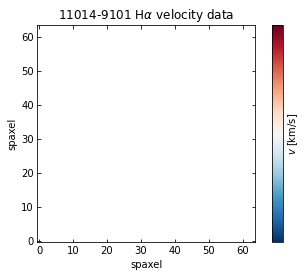

In [194]:
plot_vel(mHa_vel, 
         gal_id, 
         FOLDER_NAME='',
         FILENAME_SUFFIX='_Ha_map.'
        )

In [192]:
def plot_vel(vel, 
             gal_ID, 
             V_type='Ha', 
             model=False,
             IMAGE_DIR=None, 
             FOLDER_NAME=None, 
             IMAGE_FORMAT='eps', 
             FILENAME_SUFFIX=None, 
             ax=None):
    '''
    Creates a plot of the velocity map.
    Parameters:
    ===========
    vel : numpy array of shape (n,n)
        velocity map
    gal_ID : string
        [MaNGA plate] - [MaNGA IFU]
    V_type : string
        Velocity field type.  Default is 'Ha' = H-alpha.
        
    model : boolean
        If true, then what is being plotted is the model velocity map, and the 
        title of the plot will reflect this.  If false (default), then the data 
        is assumed to be plotted, and the title of the plot will reflect this.
    IMAGE_DIR : string
        Path of directory to store images
    FOLDER_NAME : string
        Name of folder in which to save image
    IMAGE_FORMAT : string
        Format of saved image.  Default is eps
    FILENAME_SUFFIX : string
        Suffix to append to gal_ID to create image filename
    ax : matplotlib.pyplot figure axis object
        Axes handle on which to create plot
    '''


    if ax is None:
        fig, ax = plt.subplots()


    ############################################################################
    # Determine limits of color scale
    #---------------------------------------------------------------------------
    minimum = ma.min(vel)
    maximum = ma.max(vel)

    if minimum > 0:
        vmax_bound = maximum
        vmin_bound = 0
    else:
        vmax_bound = np.max( [np.abs(minimum), np.abs(maximum)])
        vmin_bound = -vmax_bound

    cbar_ticks = np.linspace( vmin_bound, vmax_bound, 11, dtype='int')
    ############################################################################


    ############################################################################
    # Create plot title
    #---------------------------------------------------------------------------
    if model:
        map_type = 'model'
    else:
        map_type = 'data'

    if V_type == 'Ha':
        vel_type = r' H$\alpha$'
    else:
        vel_type = ' stellar'

    ax.set_title(gal_ID + vel_type + ' velocity ' + map_type)
    ############################################################################
    

    ############################################################################
    # Create plot
    #---------------------------------------------------------------------------
    vel_im = ax.imshow( vel, 
                        cmap='RdBu_r', 
                        origin='lower', 
                        vmin=vmin_bound, 
                        vmax=vmax_bound)

    cbar = plt.colorbar( vel_im, ax=ax, ticks=cbar_ticks)
    cbar.ax.tick_params( direction='in')
    cbar.set_label('$v$ [km/s]')

    ax.tick_params( axis='both', direction='in')
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.set_xlabel('spaxel')
    ax.set_ylabel('spaxel')
    '''
    ax.set_xlabel('$\Delta \alpha$ [arcsec]')
    ax.set_ylabel('$\Delta \delta$ [arcsec]')
    '''
    ############################################################################


    
    if IMAGE_DIR is not None:
        ########################################################################
        # Create output directory if it does not already exist
        #-----------------------------------------------------------------------
        if not os.path.isdir( IMAGE_DIR + FOLDER_NAME):
            os.makedirs( IMAGE_DIR + FOLDER_NAME)
        ########################################################################

        ########################################################################
        # Save figure
        #-----------------------------------------------------------------------
        plt.savefig( IMAGE_DIR + FOLDER_NAME + gal_ID + FILENAME_SUFFIX + IMAGE_FORMAT, 
                     format=IMAGE_FORMAT)
        ########################################################################

        ########################################################################
        # Figure cleanup
        #-----------------------------------------------------------------------
        plt.cla()
        plt.clf()
        plt.close()
        del cbar, vel_im
        gc.collect()